Proyecto: 
**Señales Sintéticas ECG**



Grupo 3, Tema 4, Horario 2

Integrantes:

*   José Andrés Reyes Cisneros
*   Sebastian Adolfo Rios Quintanilla
*   Luis Gustavo Loja Mauricio
*   Gloria Kimberly Paucar Centeno
*   José Enrique Cebrían Baca


El código a continuación corresponde a la elaboración y entrenamiento de un modelo simple de GAN haciendo uso de redes neuronales convolucionales de 1 dimensión. Los datos usados corresponden únicamente a la primera derivación de ECG por temas de consistencia y practicidad

In [ ]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import model_from_json
from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal
import pickle
import seaborn as sns
from sklearn.manifold import TSNE

La función FullPreproc aplica un filtro de paso de banda a las señales de ECG para eliminar el cambio de linea base y suavizar las señales, pues es díficil  para las capas convolucionales modelar ruido. Además, en la práctica se encontró que suavizar la señal usando una media móvil también mejora el resultado.

In [ ]:
def FullPreproc(signal):
  #Esta función asume un fs=100
  signal = signal.values
  b, a = scipy.signal.butter(5, [1,35], 'bandpass',fs=100)
  filtered = scipy.signal.filtfilt(b, a , signal)
  rolled = pd.Series(filtered).rolling(window=3).mean()[250:750]
  return rolled

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Para la elaboración de la arquitectura de la GAN se siguieron las siguientes recomendaciones. Estas son originalemnte dadas para GANs para imágenes, pero también funcionan con series temporales.

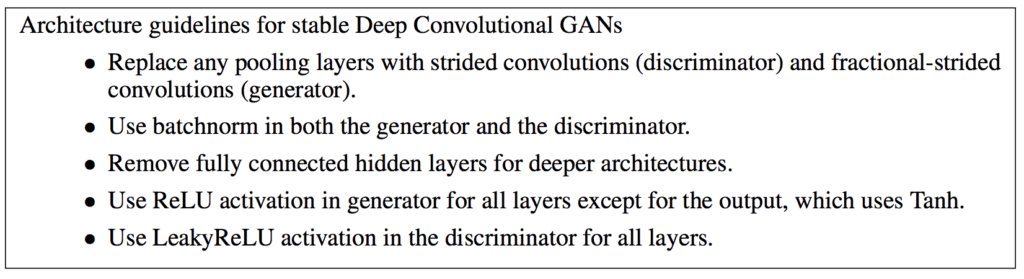

A continuación se presenta la clase GAN. La clase contiene varios métodos y se va a explicar cada uno. Se usó programación orientada a objetos para facilitar la reproductibilidad del código y el orden:



*   Al crearse una instancia de GAN se añade información del dataset que se va a usar. Esto es para que la ejecución de otros métodos sea más sencilla.
*   El método Datos Reales, obtiene una cantidad definida por el usuario de datos del dataset con el cual se inició la instancia. Dependiendo de si estos datos serán o no serán usados para entrenamiento se cambian de forma o no.
*   El método latent-space genera un conjunto de datos extraidos de una distribución normal. Su longitud está definida por el usuario y se usarán para alimentar al Generador.
* El método Datos_Falsos usa al generador para obtener una muestra de datos sintéticos. Su cantidad depende del usuario y usa el método latent_space para generarlos. 
* Los métodos Crear Discriminador y Crear Generador realzian las funciones de sus nombres, el número de inputs del generador está definido con por el usuario, pero este tiene que ser igual al n_outputs del generador, y a su vez el n_inputs del generador debe ser el mismo que la longitud de los datos del latent_space.
*El método crear GAN, crea una arquitectura de GAN poniendo al generador en la entrada del discriminador y usa la función de pérdida Adam.


El método train tiene el propósito de completar el entrenamiento de la GAN, esta se compone en varias etapas:

*   En primer lugar se intenta cargar el modelo anterior, esto incluye una lista de épocas y una lista que contiene la pérdida del generador. La carga se intenta realizar de un checkpoint almacenado en google drive, con el método "load_model"
*  Luego se realiza el entrenamiento por un bucle que cubre el número total de épocas de entrenamiento. El entrenamiento se realiza en batch, y el tamaño de batch como el número de épocas se definen con anterioridad. 
* Inicialmente se entrena el discriminador. Se activa el entrenamiento para este y se entrena en batch con los datos reales, obtenidos con el método Datos_Reales y luego con los datos sintéticos, obtenidos con el método Datos_Falsos. 
* Posteriormente se desactiva la condición de entrenable del discrimandor y se entrena la GAN. La GAN está compuesta por el discriminador y el generador. Para el entrenamiento se usan los datos sintéticos pero con un label de verdaderos. Esto resulta en un valor de loss muy alto, y como el discriminador está desactivado para entrenamiento, se actualizan únicamente los parámetros del generador. 

*   Existen 3 checkpoints
  * Cada 250 datos se almacena la época y el valor del val_loss. Esto es para poder graficarlos
  * Cada 1000 datos se grafica una muestra de señal sintética, obtenida del generador, el val_loss a lo largo de las épocas, y un gráfico de T-SNE para comparar las distribuciones entre los datos reales y sintéticos.
  * Cada 10000 datos se guarda el modelo automáticamente en drive. Esto incluye su arquitectura, los pesos, las épocas y el val loss.





In [ ]:
class GAN:
  def __init__(self, dataset):
    self.dataset = dataset

  ## MÉTODOS DE DISCRIMINADOR
  def Crear_Discriminador(self,n_inputs): #El discriminador tiene que ser más tonto
    self.discriminador=Sequential()
    self.discriminador.add(Conv1D(filters=8, kernel_size=5, activation='LeakyReLU', input_shape=(n_inputs,1)))
    self.discriminador.add(BatchNormalization()) 
    self.discriminador.add(tensorflow.keras.layers.LeakyReLU())
    self.discriminador.add(MaxPooling1D(pool_size=3))

    self.discriminador.add(Conv1D(filters=16,kernel_size=5, input_shape = (n_inputs,1)))
    self.discriminador.add(BatchNormalization()) 
    self.discriminador.add(tensorflow.keras.layers.LeakyReLU())
    self.discriminador.add(MaxPooling1D(pool_size=3))
   
    self.discriminador.add(Conv1D(filters=32,kernel_size=5)) #Actialización 13/05/2022
    self.discriminador.add(BatchNormalization()) 
    self.discriminador.add(tensorflow.keras.layers.LeakyReLU())
    self.discriminador.add(MaxPooling1D(pool_size=3))
   
    self.discriminador.add(Conv1D(filters=64,kernel_size=5)) #Actialización 13/05/2022
    self.discriminador.add(BatchNormalization()) 
    self.discriminador.add(tensorflow.keras.layers.LeakyReLU())
    self.discriminador.add(MaxPooling1D(pool_size=3))
    self.discriminador.add(Flatten())
    
    self.discriminador.add(Dense(20))
    self.discriminador.add(tensorflow.keras.layers.LeakyReLU())
    self.discriminador.add(Dense(1, activation='sigmoid'))

    self.discriminador.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return self.discriminador  

  def Datos_Reales(self,n_datos,to_disc=False):
    self.muestras = self.dataset.sample(n=n_datos)
    self.X_reales = self.muestras.values
    if to_disc==True:
      self.X_reales = self.X_reales.reshape(self.X_reales.shape[0],self.X_reales.shape[1],1) #Se asigna un canal en 3 dimensiones 
    self.y_reales = np.ones((n_datos,1))
    return self.X_reales,self.y_reales
  
  ## MÉTODOS DE GENERADOR
  def Crear_Generador(self, dimension, n_outputs=1000):
    self.generador = Sequential()

    self.generador.add(Conv1D(filters=32, kernel_size=3, input_shape=(dimension,1)))
    self.generador.add(BatchNormalization()) 
    self.generador.add(tensorflow.keras.layers.LeakyReLU())
    self.generador.add(MaxPooling1D(pool_size=3))

    self.generador.add(Conv1D(filters=64, kernel_size=3)) 
    self.generador.add(BatchNormalization()) 
    self.generador.add(tensorflow.keras.layers.LeakyReLU())
    self.generador.add(MaxPooling1D(pool_size=3))
    
    self.generador.add(Flatten())
    self.generador.add(BatchNormalization()) 
    self.generador.add(Dense(n_outputs, activation='linear'))
    self.generador.compile()
    return self.generador

  def Datos_Falsos(self,dimension,n_datos,to_plot=False):
    #Dimensión representa la longitud del latentspace, n_datos representa el tamaño del batch
    self.X_in = self.latent_space(dimension,n_datos) 
    self.X_gen = self.generador.predict(self.X_in)
    if to_plot == False:
      self.X_gen = self.X_gen.reshape(self.X_gen.shape[0],self.X_gen.shape[1],1)
    self.y_gen = np.zeros((n_datos,1)) #Estos datos se consideran falsos
    return self.X_gen,self.y_gen

  def latent_space(self, dimension, n_datos):
    self.x_latent = np.random.normal(size=(n_datos,dimension))
    return self.x_latent 
  
  #GAN
  def Crear_Gan(self):
    #self.discriminador.trainable = False
    self.gan = Sequential()
    self.gan.add(self.generador) 
    self.gan.add(self.discriminador)
    self.gan.compile(loss='binary_crossentropy',optimizer='adam')
    #self.gan.compile(loss='categorical_crossentropy',optimizer='adam') #Actualización 13/05/2022
    return self.gan

  def train(self, dimensiones, epocas, n_batch):
    #Se va a entrenar en batch
    medio_batch = int(n_batch/2)

    try:
      epoca_real = list(filter(lambda x:x%10000==0,self.epocas_list))[-1]
      indexación = self.epocas_list.index(epoca_real)
      self.epocas_list = self.epocas_list[:indexación+1]
      self.val_loss = self.val_loss[:indexación+1]
      print("Todo Cargado Correctamente")
    except:
      epoca_real = 0

    for i in range(epocas):
      #Entrenar Discriminador
      self.discriminador.trainable = True #Se activa el entrenamiento del discriminador
      X_real,y_real = self.Datos_Reales(medio_batch,to_disc=True) #Entrenar con datos reales de ECG
      self.discriminador.train_on_batch(X_real,y_real)
      X_falso,y_falso = self.Datos_Falsos(dimensiones,medio_batch) #Entrenar con datos falsos del generador
      self.discriminador.train_on_batch(X_falso,y_falso)

      #Entrenar GAN
      self.discriminador.trainable = False #Se desactiva el discriminador para que se entrene solo el generador
      X_gan = self.latent_space(dimensiones, n_batch) #Datos latentes para alimentar el generador
      y_gan = np.ones((n_batch,1)) #Ahora estamos diciendole al modelo que estos datos son reales
      self.gan.train_on_batch(X_gan,y_gan) #Se entrena la GAN. El generador recibe unicamente los datos latentes.

      #Guardar Modelo
      if ((i+1)%10000==0):
        print('Checkpoint en época: {}'.format(epoca_real))
        
        generador_json = self.generador.to_json()
        with open("/content/drive/MyDrive/ISB/DatosDelModelo/generador.json", "w") as genera_json:
          genera_json.write(generador_json)
        self.generador.save_weights("/content/drive/MyDrive/ISB/DatosDelModelo/generador_weights.h5")

        discriminador_json = self.discriminador.to_json()
        with open("/content/drive/MyDrive/ISB/DatosDelModelo/discriminador.json", "w") as discrimina_json:
          discrimina_json.write(discriminador_json)
        self.discriminador.save_weights("/content/drive/MyDrive/ISB/DatosDelModelo/discriminador_weights.h5")

        with open("/content/drive/MyDrive/ISB/DatosDelModelo/val_loss_list.pkl","wb") as loss_values:
          pickle.dump(self.val_loss, loss_values)
        
        with open("/content/drive/MyDrive/ISB/DatosDelModelo/epocas_list.pkl","wb") as epocas_values:
          pickle.dump(self.epocas_list, epocas_values)       

      if ((i+1)%250==0) & ((i+1)%1000!=0):
        X_falsos,_ = self.Datos_Falsos(dimensiones,1,to_plot=True)
        score = self.discriminador.evaluate(X_falsos,np.ones(1),verbose=0)

        try:
          self.val_loss.append(score[0])
        except:
          self.val_loss.append(score)
          
        self.epocas_list.append(epoca_real)

      if ((i+1)%1000==0) or (i==0):
        X_falsos,_ = self.Datos_Falsos(dimensiones,1,to_plot=True)
        score = self.discriminador.evaluate(X_falsos,np.ones(1),verbose=0)
        probability = self.discriminador.predict(X_falsos)

        try:
          print('Loss: ',score[0])
          self.val_loss.append(score[0])
        except:
          print("Algo raro ha pasado")
          print('Loss: ',score)
          self.val_loss.append(score)

        print('Probabilidad: ',probability) #Probabilidad de ser clasificada cmo real
        self.epocas_list.append(epoca_real)
        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(14,6))
        ax[0].plot(X_falsos[0,:])
        ax[0].set_title('Señal falsa en epoca: '+str(epoca_real))
        ax[1].plot(self.epocas_list,self.val_loss)
        ax[1].set_title('Loss')

        #PLOTEAR TSNE
        #Generar datos falsos:
        n_datos = 100
        datos = np.zeros((n_datos,500))
        for i in range(n_datos):
          feik,_=self.Datos_Falsos(50,1,to_plot=True)
          datos[i] = feik
        Datos_Generados = pd.DataFrame(datos, columns=df_procesada_standar.columns)
        Datos_Generados['Tipo'] = "Artificial"

        #Generar datos reales:
        Datos_Reales = self.dataset.sample(n_datos)
        Datos_Reales['Tipo'] = "Real"
        Conjunto_General = pd.concat([Datos_Generados,Datos_Reales],axis=0).reset_index(drop=True)

        model = TSNE(learning_rate=20)
        transformed = model.fit_transform(Conjunto_General.drop("Tipo",axis=1))
        xs = transformed[:,0]
        ys = transformed[:,1]
        sns.scatterplot(xs,ys,hue=Conjunto_General["Tipo"],ax=ax[2])
        plt.show()

      epoca_real = epoca_real + 1

        

  def load_model(self,ruta_generador, ruta_discriminador,new_model=False):
    if new_model == False:
      self.generador.load_weights(ruta_generador)
      self.discriminador.load_weights(ruta_discriminador)

    try:
      with open("/content/drive/MyDrive/ISB/DatosDelModelo/val_loss_list.pkl", "rb") as val_list:
        self.val_loss = pickle.load(val_list)
      self.val_loss = list(map(lambda x:x+1, self.val_loss))
      print("Val cargado correctamente ")

      with open("/content/drive/MyDrive/ISB/DatosDelModelo/epocas_list.pkl","rb") as epoc_list:
        self.epocas_list = pickle.load(epoc_list)
      self.epocas_list = list(map(lambda x:x+1, self.epocas_list))
      print("Epocas cargado correctamente ")

    except:
      self.val_loss = []
      self.epocas_list = []

Se importa, se preprocesan y se estandarizan los datos para que la media sea 0 y la desviación estándar 1. Esto mejora la performance del modelo. El preprocesamiento, como indicado anteriormente, incluye la aplicación de un filtro de paso de banda y una media móvil. 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ISB/DatosDerivada1.csv')
df_procesada = df.apply(FullPreproc, axis=1)
df_procesada_standar = (df_procesada-df_procesada.mean())/df_procesada.std()

In [ ]:
df_procesada_standar

250       251       252       253       254       255       256  \
0     -0.359898 -0.355359 -0.357717 -0.369927 -0.388056 -0.465622 -0.543647   
1      0.045702  0.304915  0.540850  0.853602  1.275165  1.695196  1.988168   
2     -0.359798 -0.379250 -0.410605 -0.436475 -0.448461 -0.434528 -0.388434   
3     -0.194880 -0.246823 -0.328653 -0.392773 -0.404462 -0.410504 -0.428725   
4      0.825611  0.531756  0.242070  0.051312 -0.071273 -0.174272 -0.241935   
...         ...       ...       ...       ...       ...       ...       ...   
21832 -1.458770 -1.148621 -0.943876 -0.800585 -0.764997 -0.811072 -0.808520   
21833 -0.276659 -0.247859 -0.248381 -0.261706 -0.236609 -0.168377 -0.122078   
21834  0.026280  0.046461 -0.008980 -0.029257  0.025832  0.029008 -0.092537   
21835  0.020858 -0.030912 -0.074937 -0.052907  0.007170  0.002897 -0.087599   
21836 -0.212125 -0.202272 -0.166570 -0.085569  0.021754  0.045267 -0.076006   

            257       258       259  ...       740       741       742  \
0     -0.468344 -0.243849 -0.041539  ... -0.156313 -0.187428 -0.224464   
1      2.196535  2.417837  2.618926  ... -0.634959 -0.674338 -0.699900   
2     -0.340240 -0.314499 -0.295601  ... -0.266100 -0.338819 -0.349819   
3     -0.402787 -0.340734 -0.307678  ... -0.598388 -0.514504 -0.398662   
4     -0.248318 -0.240044 -0.296344  ...  0.041975 -0.083523 -0.178370   
...         ...       ...       ...  ...       ...       ...       ...   
21832 -0.763905 -0.768261 -0.799407  ... -0.313646 -0.209299 -0.330215   
21833 -0.120982 -0.122120 -0.117718  ... -0.474197 -0.425453 -0.389038   
21834 -0.206289 -0.231470 -0.203734  ... -0.021733 -0.072661 -0.141969   
21835 -0.157509 -0.156515 -0.159096  ... -0.307671 -0.358316 -0.348076   
21836 -0.232534 -0.306235 -0.298516  ... -0.307700 -0.257000 -0.200361   

            743       744       745       746       747       748       749  
0     -0.243479 -0.266065 -0.286032 -0.261305 -0.202202 -0.130795 -0.038528  
1     -0.700164 -0.754224 -0.614946  0.411479  1.925599  2.187246  0.482739  
2     -0.327784 -0.346045 -0.393345 -0.409071 -0.372797 -0.283523 -0.150546  
3     -0.326067 -0.296992 -0.225794 -0.082649  0.071324  0.179825  0.249726  
4     -0.208265 -0.214777 -0.197385 -0.168089 -0.174694 -0.203528 -0.191578  
...         ...       ...       ...       ...       ...       ...       ...  
21832 -0.601091 -0.309964  1.648804  4.650681  5.983650  4.204094  0.971962  
21833 -0.342595 -0.284498 -0.239957 -0.223156 -0.237970 -0.279987 -0.304396  
21834 -0.187042 -0.168810 -0.114604 -0.064288 -0.034779 -0.048889 -0.104277  
21835 -0.359864 -0.393393 -0.384474 -0.348113 -0.324065 -0.304749 -0.268588  
21836 -0.138472 -0.094706 -0.066608 -0.011702  0.027864 -0.040497 -0.181012  

[21837 rows x 500 columns]

A continuación se muestra una señal de ECG, estandarizada y con los filtros aplicadoos

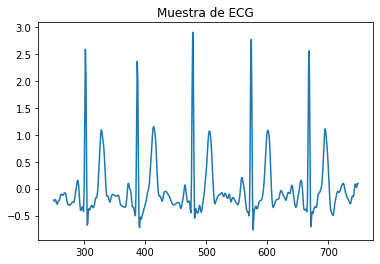

In [ ]:
plt.plot(df_procesada_standar.iloc[125])
plt.title('Muestra de ECG')
plt.show()

Este es el código que se sigue para el entrenamiento, lamentablemente muchos de los intentos de entrenamiento se han perdido, pero este es el que ha tenido mejores resultados. Para este se usó un espacio latente de 50, y una señal de 500.

In [ ]:
modelo = GAN(df_procesada_standar)
modelo.Crear_Discriminador(n_inputs=500)
modelo.Crear_Generador(dimension=50,n_outputs=500)
modelo.Crear_Gan()
#modelo.load_model("","",True) Esto es para un nuevo modelo
modelo.load_model("/content/drive/MyDrive/ISB/DatosDelModelo/generador_weights.h5",
                  "/content/drive/MyDrive/ISB/DatosDelModelo/discriminador_weights.h5")

Luego de 500000 epoocas aprox se obtuvo la siguiente señal:

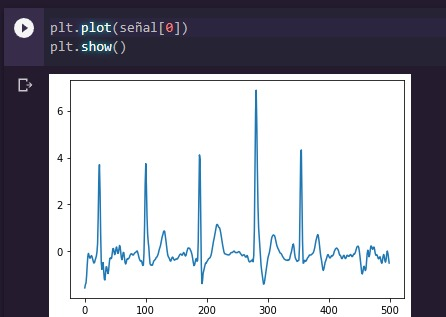

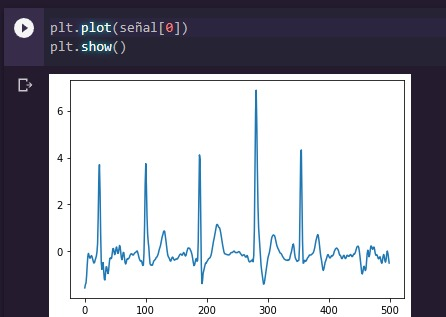

**Abajo muestro además la información correspondiente a iteraciones pasadas del modelo, incluyendo las fechas en que los comentarios fueron hechas.**


Los datos del modelo usado son:
*   latent space = 50
*   perdida = binary_cross_entropy
*   500 datos tomados en vez de mil



In [ ]:
'''
generador_json = modelo.generador.to_json()
with open("/content/drive/MyDrive/ISB/DatosDelModelo/buen_generador1.json", "w") as genera_json:
  genera_json.write(generador_json)
modelo.generador.save_weights("/content/drive/MyDrive/ISB/DatosDelModelo/buen_generador1_weights.h5")

discriminador_json = modelo.discriminador.to_json()
with open("/content/drive/MyDrive/ISB/DatosDelModelo/buen_discriminador1.json", "w") as discrimina_json:
  discrimina_json.write(discriminador_json)
modelo.discriminador.save_weights("/content/drive/MyDrive/ISB/DatosDelModelo/buen_discriminador1_weights.h5")

with open("/content/drive/MyDrive/ISB/DatosDelModelo/buen_val_loss_list1.pkl","wb") as loss_values:
  pickle.dump(modelo.val_loss, loss_values)

with open("/content/drive/MyDrive/ISB/DatosDelModelo/buen_epocas_list1.pkl","wb") as epocas_values:
  pickle.dump(modelo.epocas_list, epocas_values)  
'''
   

 Actualización 13/05/2022. Cambios:


*   Latent space aumentado a 100
*   Función de pérdida cambiada a categorical cross entropy
*   Reducción de tamaño de ECG usado a 300




In [ ]:
def FullPreproc2(signal):
  #Esta función asume un fs=100
  signal = signal.values
  b, a = scipy.signal.butter(5, [1,35], 'bandpass',fs=100)
  filtered = scipy.signal.filtfilt(b, a , signal)
  rolled = pd.Series(filtered).rolling(window=3).mean()[350:650]
  return rolled

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ISB/DatosDerivada1.csv')
df_procesada = df.apply(FullPreproc2, axis=1)
df_procesada_standar = (df_procesada-df_procesada.mean())/df_procesada.std()
df_procesada_standar.head()

In [ ]:
modelo = GAN(df_procesada_standar)
modelo.Crear_Discriminador(n_inputs=300)
modelo.Crear_Generador(dimension=100,n_outputs=300)
modelo.Crear_Gan()
#modelo.load_model("","",True)
modelo.load_model("/content/drive/MyDrive/ISB/DatosDelModelo/generador_weights.h5",
                  "/content/drive/MyDrive/ISB/DatosDelModelo/discriminador_weights.h5")


In [ ]:
modelo.train(dimensiones=100, epocas=100000, n_batch = 250)

Actualización 11/06


*   Cambio de arquitectura a cnn más tradicional
*   Denuevo se prueban con 500 puntos


In [ ]:
modelo = GAN(df_procesada_standar)
modelo.Crear_Discriminador(n_inputs=500)
modelo.Crear_Generador(dimension=100,n_outputs=500)
modelo.Crear_Gan()
#modelo.load_model("","",True)
modelo.load_model("/content/drive/MyDrive/ISB/DatosDelModelo/generador_weights.h5",
                  "/content/drive/MyDrive/ISB/DatosDelModelo/discriminador_weights.h5")

Val cargado correctamente 
Epocas cargado correctamente 


In [ ]:
modelo.train(dimensiones=100, epocas=100000, n_batch = 250)

En esta sección del código se visualiza lo que sería un reentrenamiento del mejor modelo, esperando mejorar los resultados. Gracias a los checkpoints tanto el modelo como la arquitectura se pueden actualizar.  

In [ ]:
with open('/content/drive/MyDrive/ISB/DatosDelModelo/buen_discriminador1.json','r') as discriminador_json:
  discriminador_json_cargado = discriminador_json.read()

discriminador = model_from_json(discriminador_json_cargado)
discriminador.load_weights("/content/drive/MyDrive/ISB/DatosDelModelo/buen_discriminador1_weights.h5")

with open('/content/drive/MyDrive/ISB/DatosDelModelo/buen_generador1.json','r') as generador_json:
  generador_json_cargado = generador_json.read()

generador = model_from_json(generador_json_cargado)
generador.load_weights("/content/drive/MyDrive/ISB/DatosDelModelo/buen_generador1_weights.h5")

In [ ]:
modelo = GAN(df_procesada_standar)
modelo.generador = generador
modelo.discriminador = discriminador
modelo.discriminador.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
buen_val_loss = []
buen_epocas_list = []

with open("/content/drive/MyDrive/ISB/DatosDelModelo/buen_val_loss_list1.pkl","wb") as loss_values:
  pickle.dump(buen_val_loss, loss_values)

modelo.val_loss = buen_val_loss

with open("/content/drive/MyDrive/ISB/DatosDelModelo/buen_epocas_list1.pkl","wb") as epocas_values:
  pickle.dump(buen_epocas_list, epocas_values) 

modelo.epocas_list = buen_epocas_list

Por un error de modificación en los archivos de Drive. Se ha perdido la información de val_loss y las épocas. Enrealidad la época es ~500000

Loss:  140.53781127929688
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


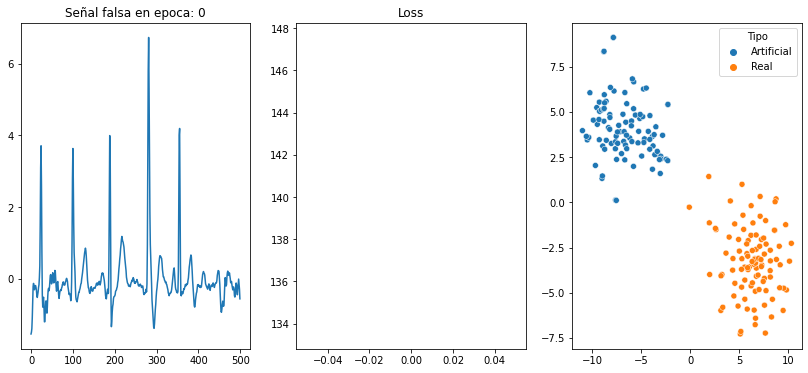

Loss:  85.4449691772461
Probabilidad:  [[7.7932995e-38]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


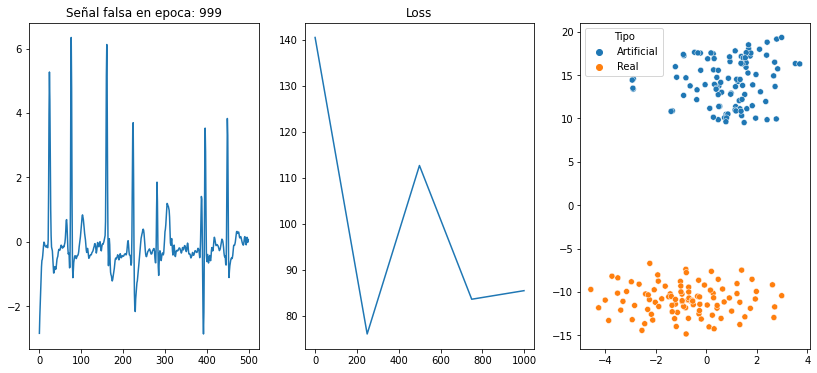

Loss:  135.462158203125
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


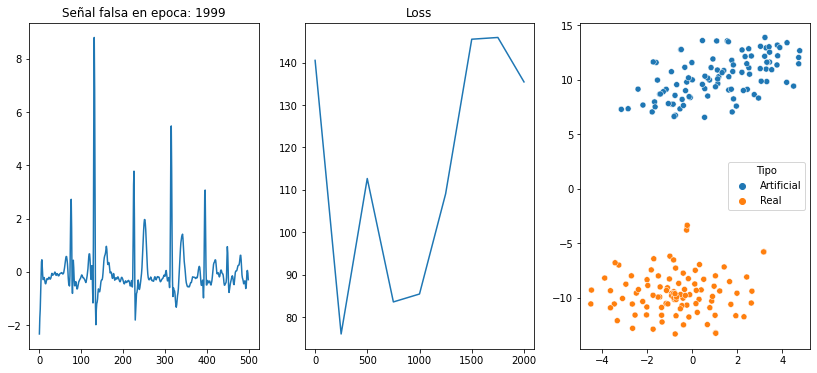

Loss:  138.6451416015625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


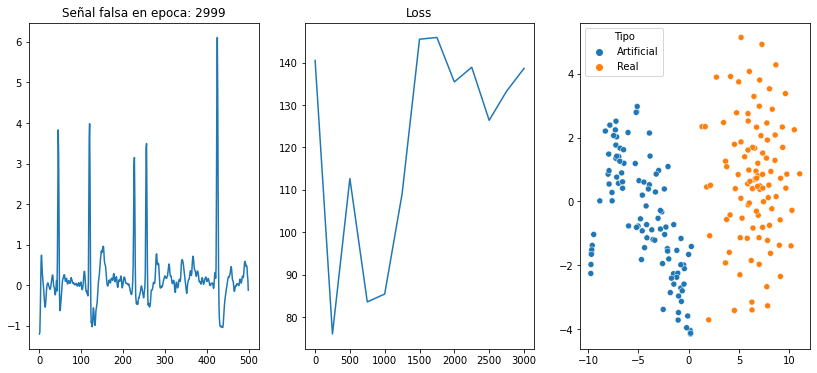

Loss:  121.36460876464844
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


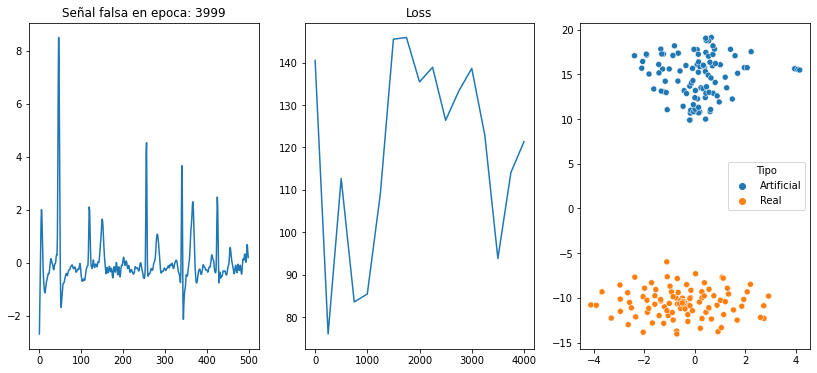

Loss:  72.86784362792969
Probabilidad:  [[2.2589031e-32]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


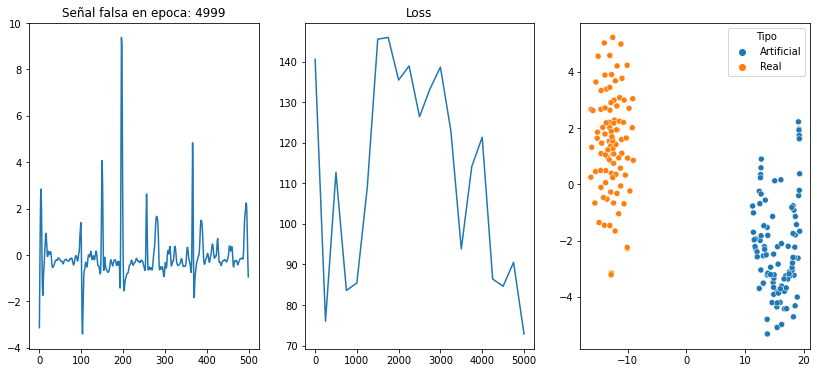

Loss:  87.56685638427734
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


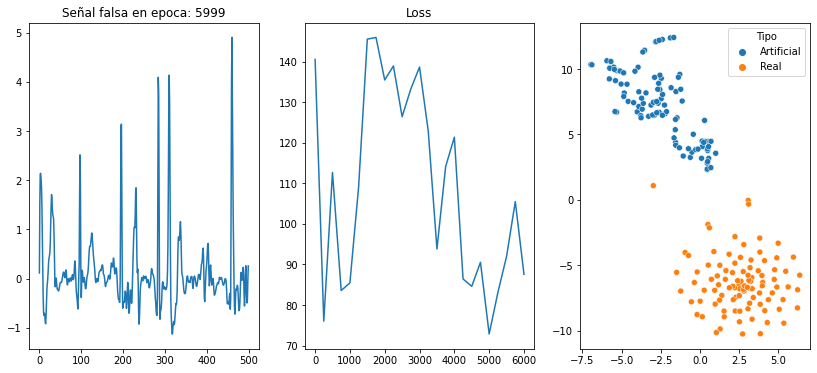

Loss:  86.71576690673828
Probabilidad:  [[2.1868597e-38]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


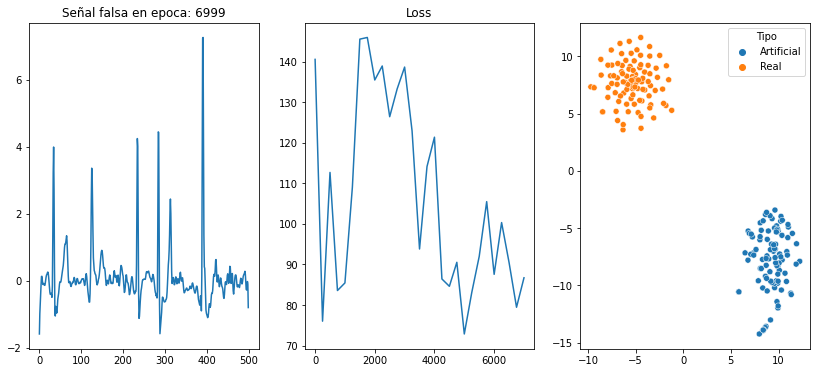

Loss:  85.50840759277344
Probabilidad:  [[7.3142606e-38]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


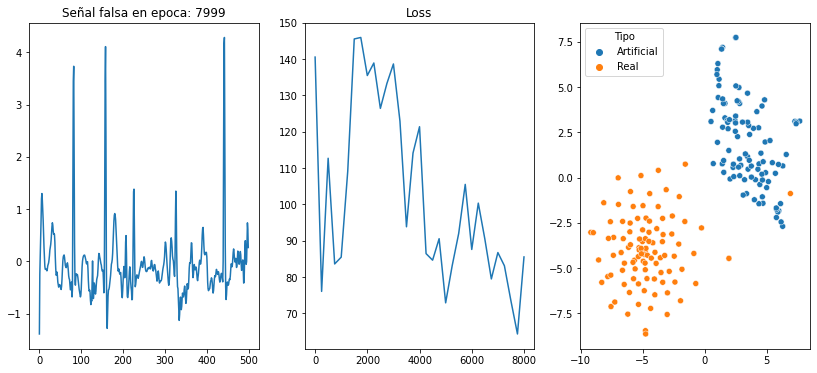

Loss:  75.09078979492188
Probabilidad:  [[2.446157e-33]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


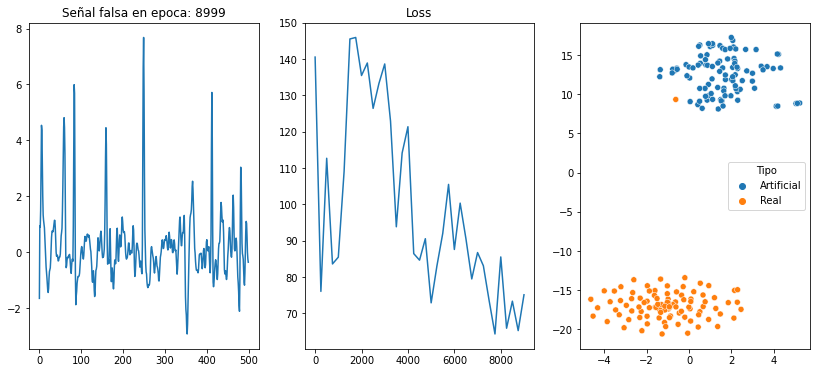

Checkpoint en época: 9999
Loss:  95.79641723632812
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


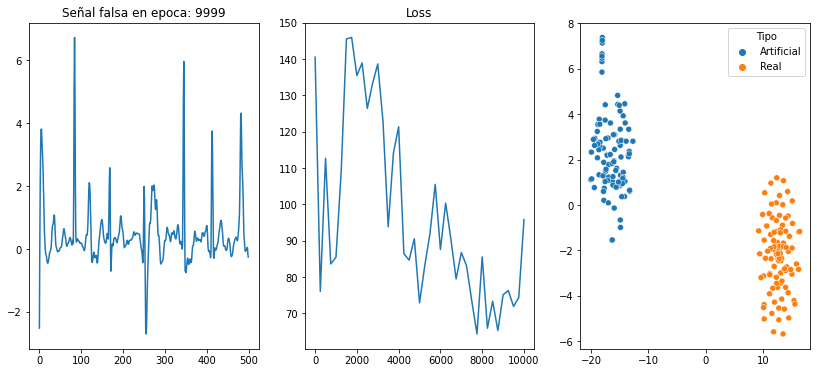

Loss:  138.336181640625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


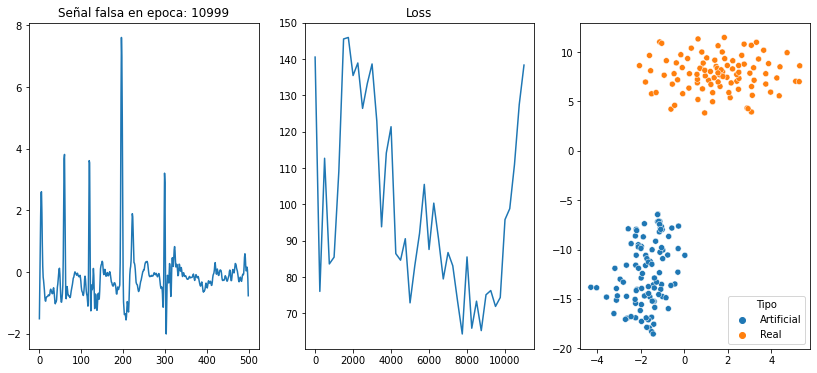

Loss:  202.6212615966797
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


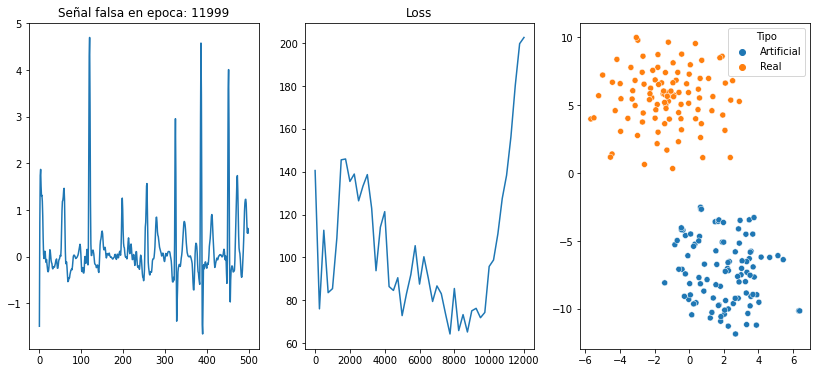

Loss:  201.11546325683594
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


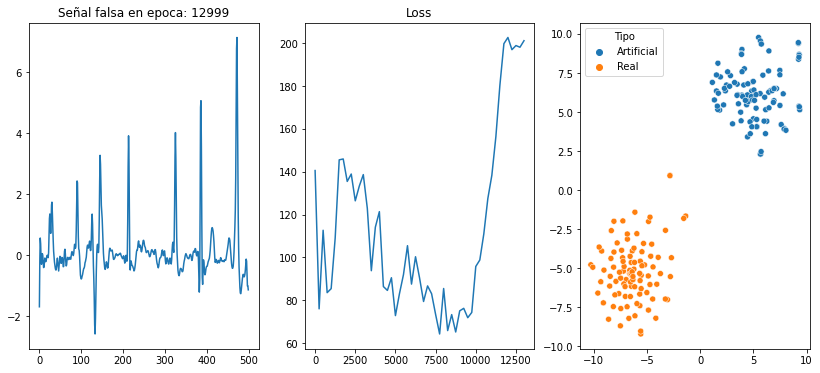

Loss:  219.3363037109375
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


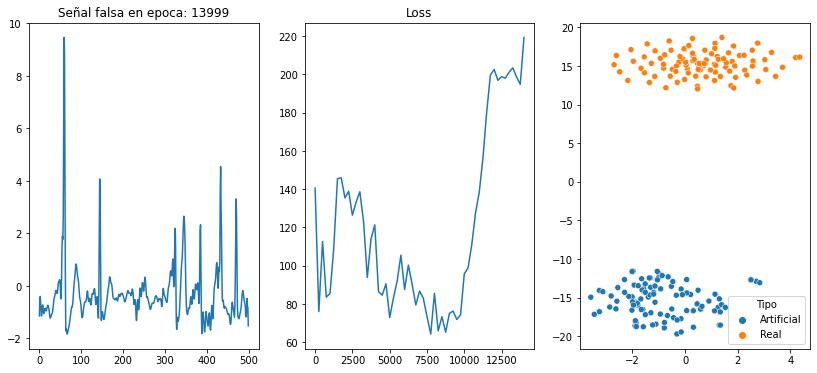

Loss:  210.32022094726562
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


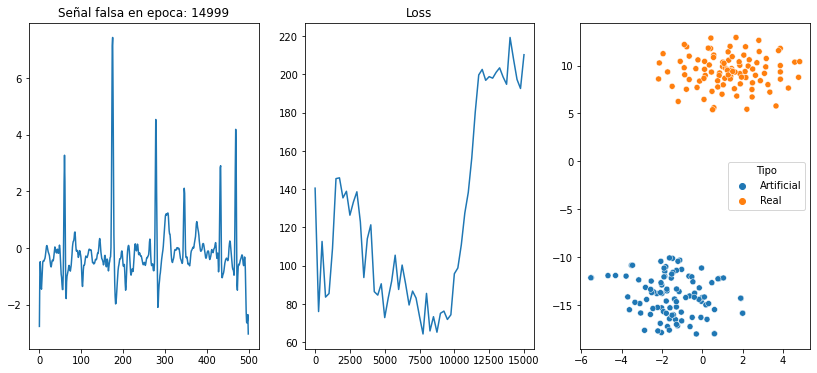

Loss:  196.7510986328125
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


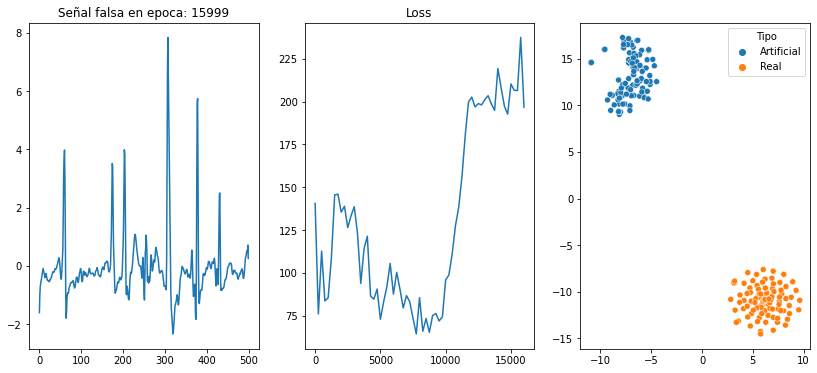

Loss:  79.489013671875
Probabilidad:  [[3.008569e-35]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


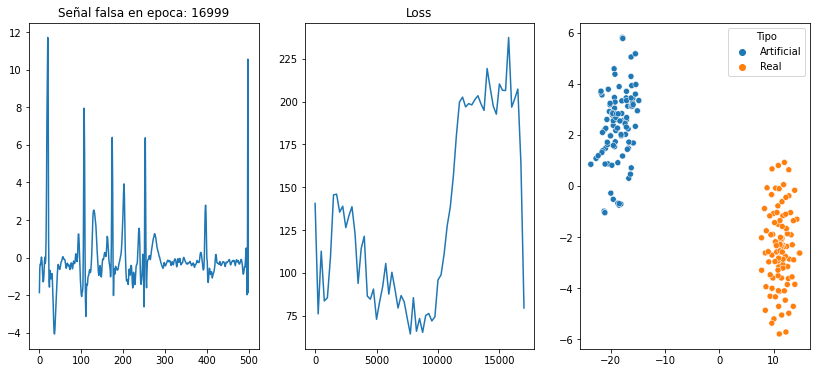

Loss:  183.3118896484375
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


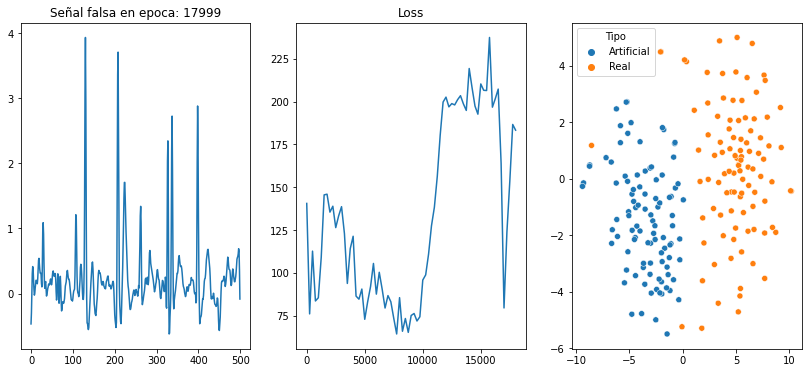

Loss:  260.2843017578125
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


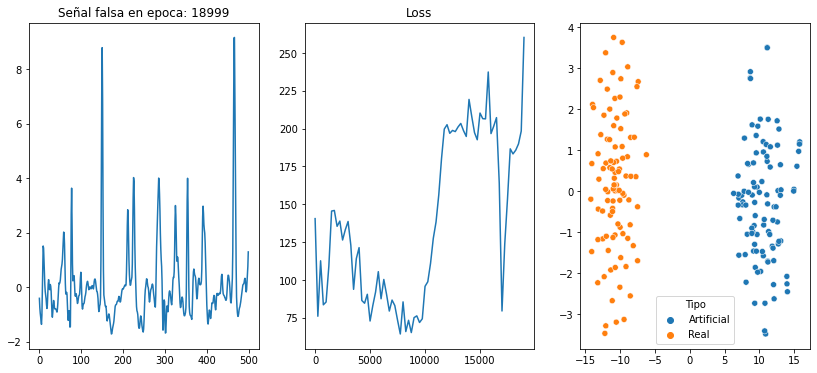

Checkpoint en época: 19999
Loss:  210.18710327148438
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


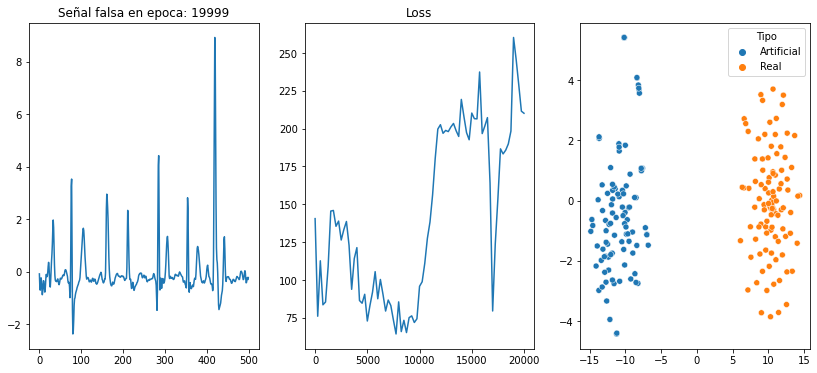

Loss:  211.94371032714844
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


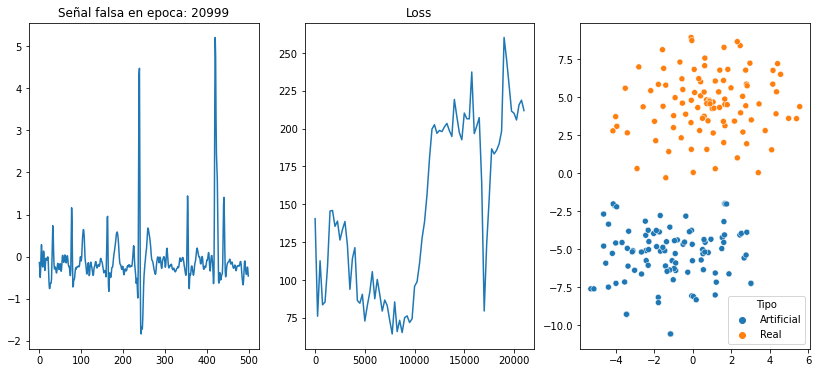

Loss:  207.11138916015625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


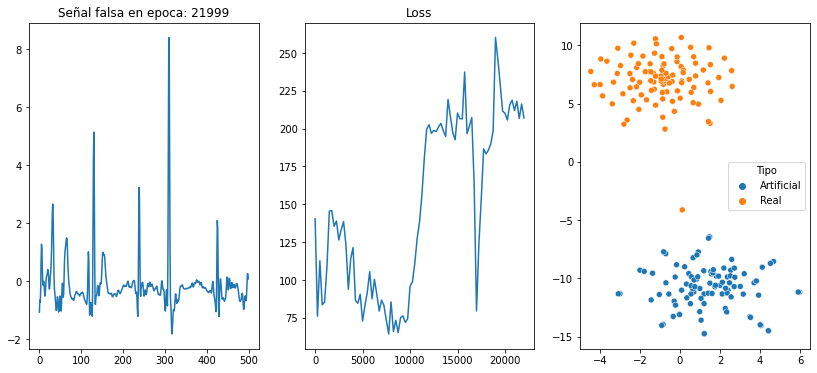

Loss:  173.3306427001953
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


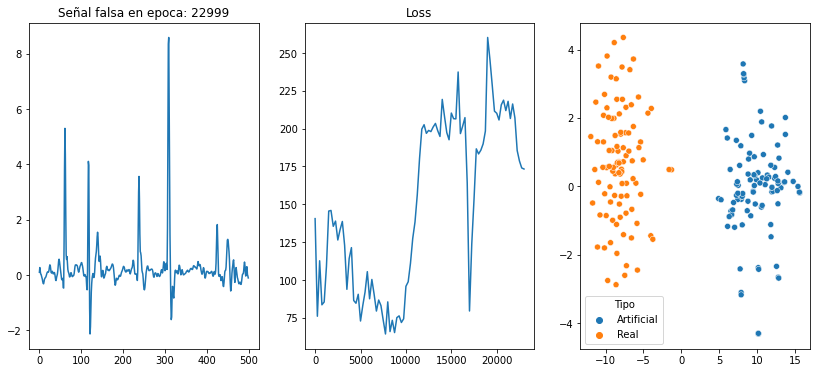

Loss:  123.80486297607422
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


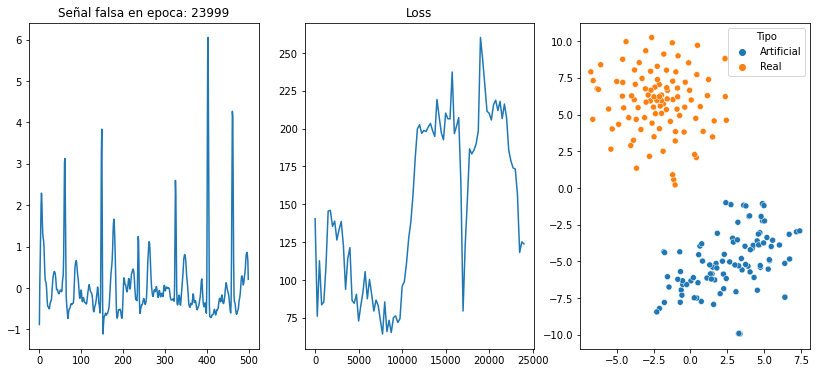

Loss:  89.86187744140625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


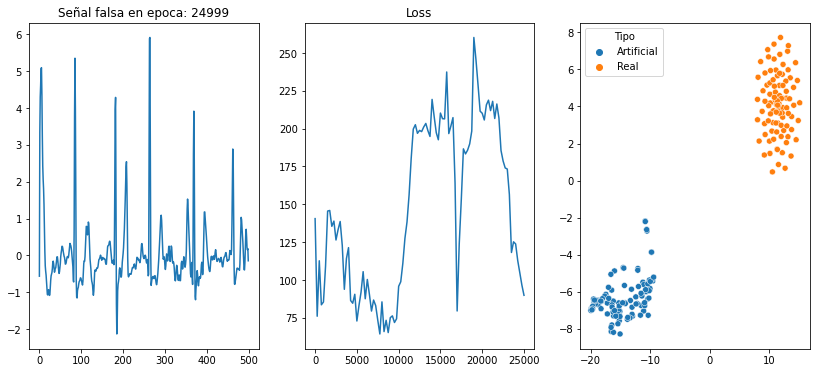

Loss:  130.85304260253906
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


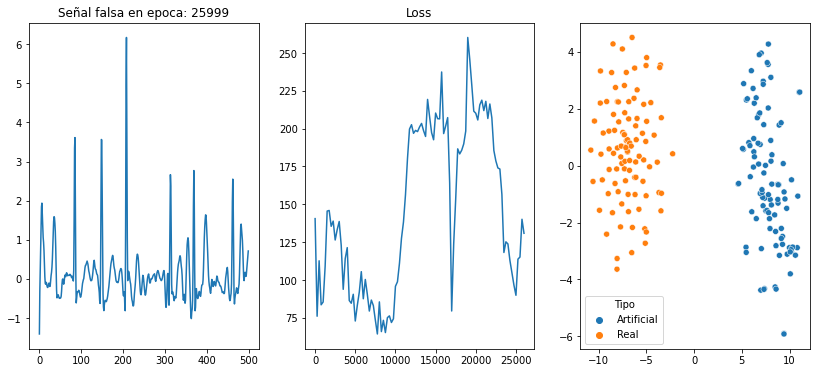

Loss:  335.2891540527344
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


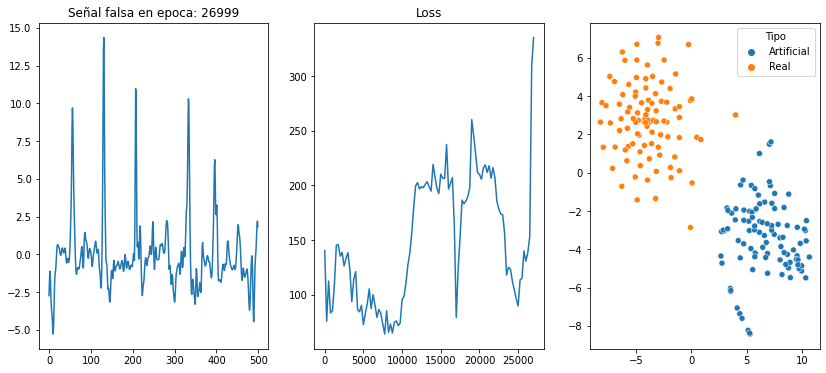

Loss:  267.29815673828125
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


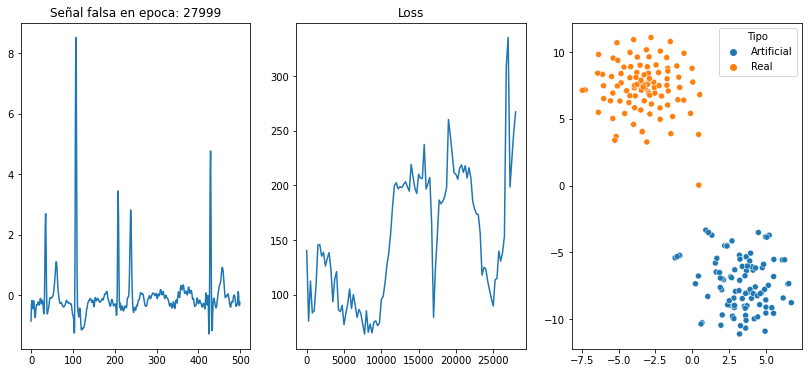

Loss:  306.1348571777344
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


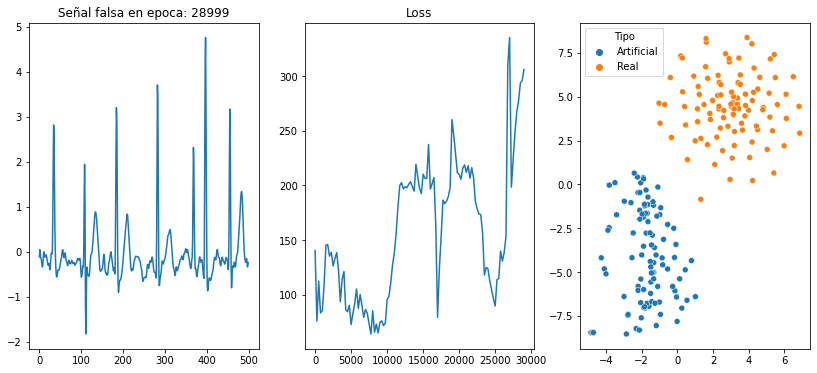

Checkpoint en época: 29999
Loss:  311.9508056640625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


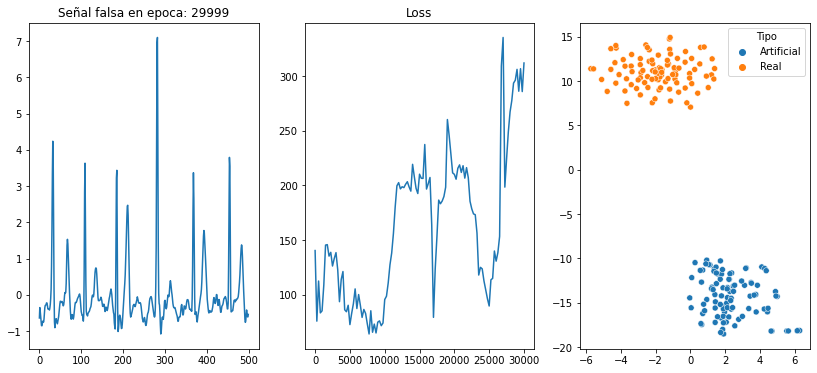

Loss:  322.3922119140625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


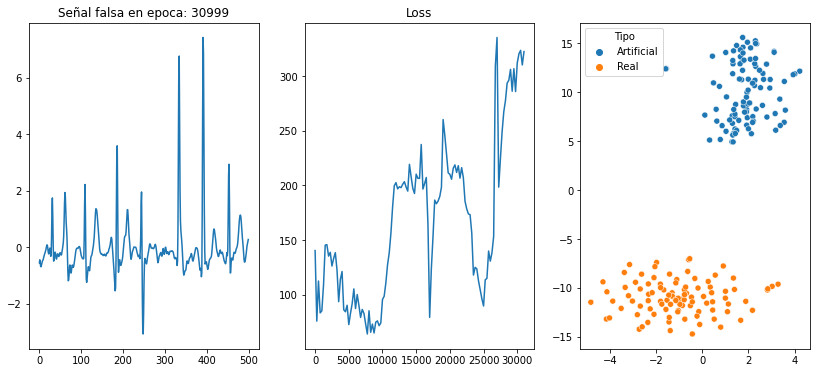

Loss:  323.89935302734375
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


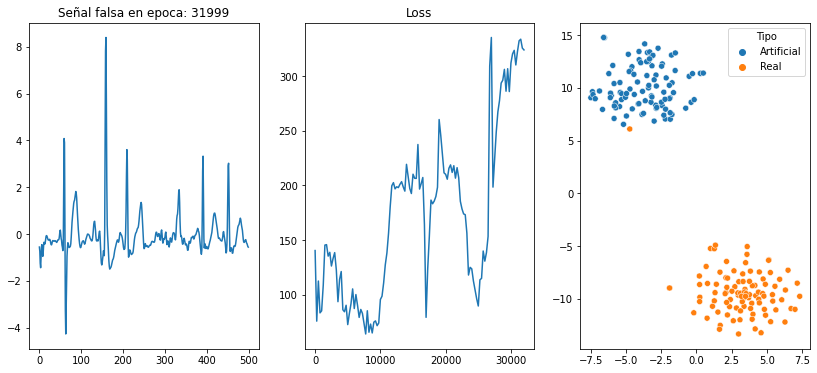

Loss:  306.4322204589844
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


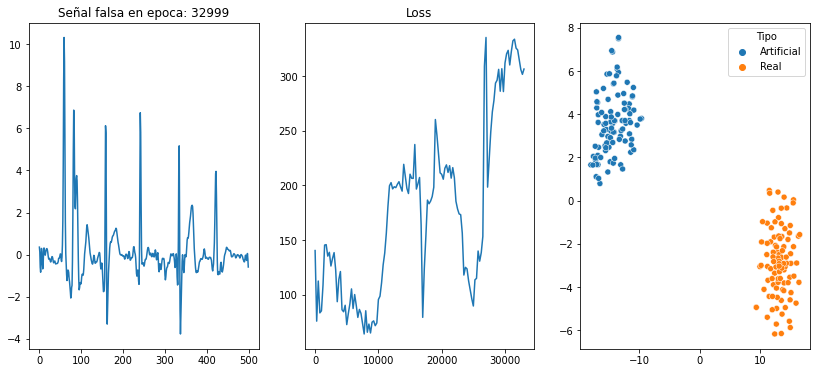

Loss:  315.1311340332031
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


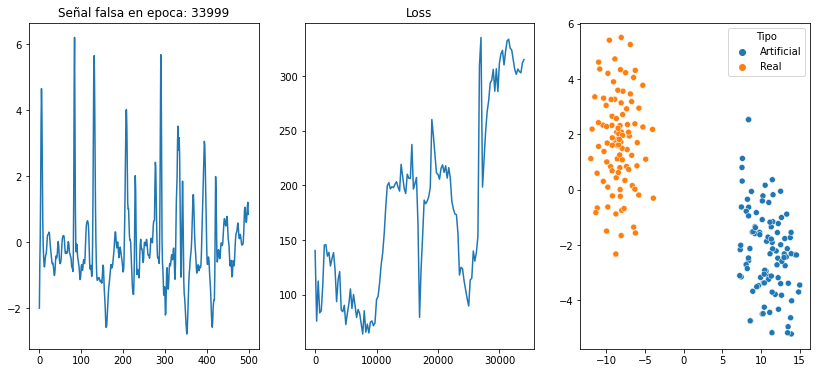

Loss:  273.046630859375
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


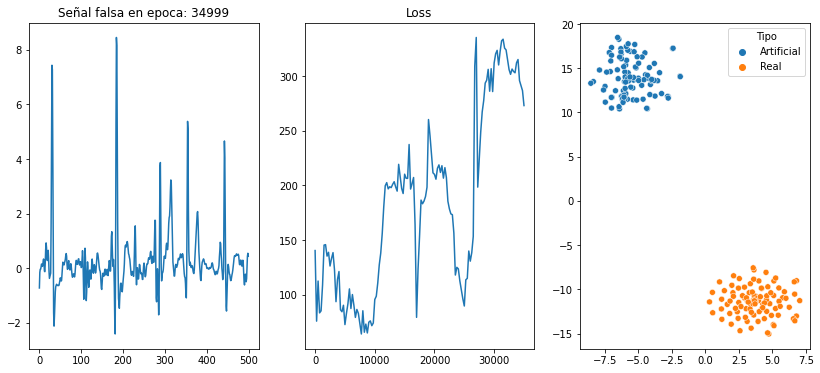

Loss:  323.4437255859375
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


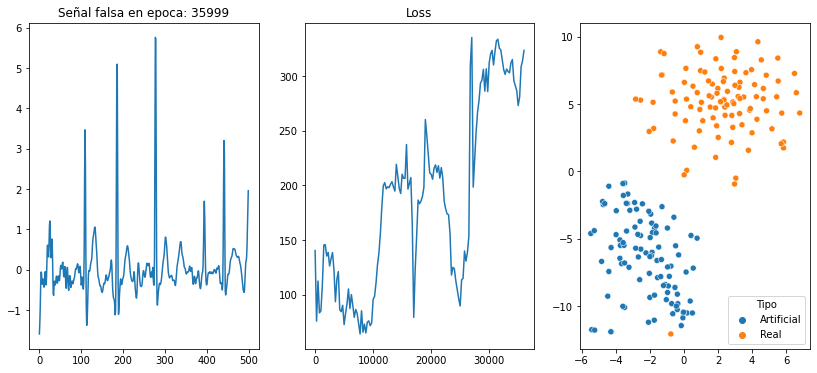

Loss:  316.2921142578125
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


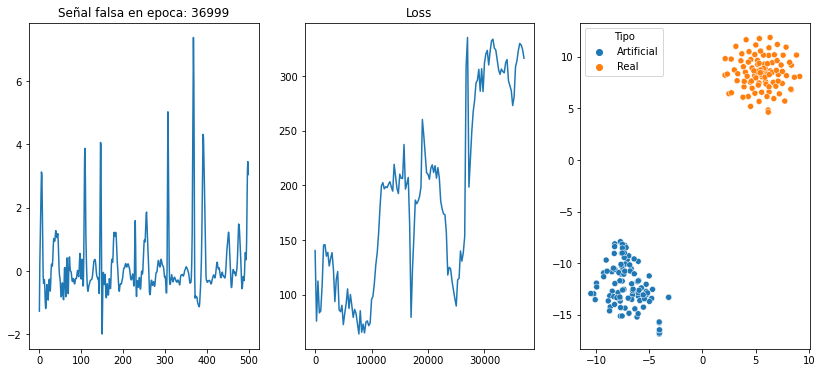

Loss:  280.4723205566406
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


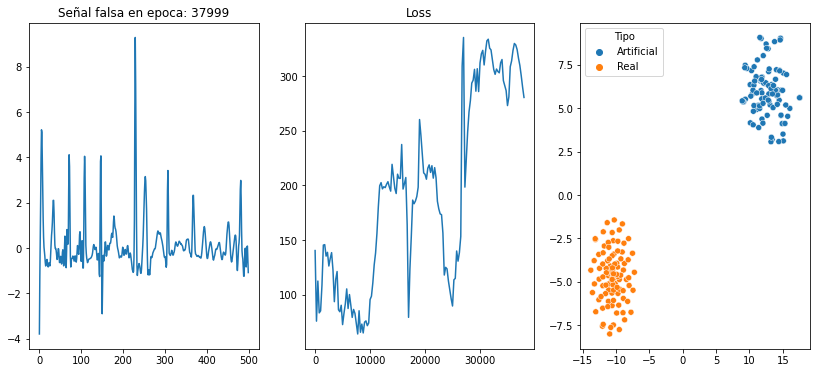

Loss:  264.68121337890625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


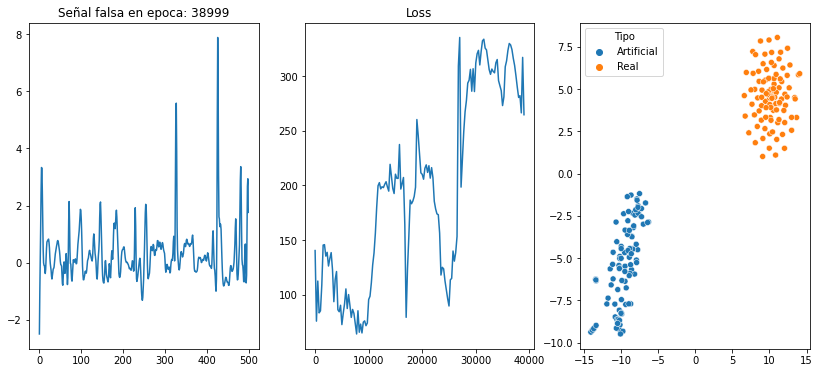

Checkpoint en época: 39999
Loss:  246.4937744140625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


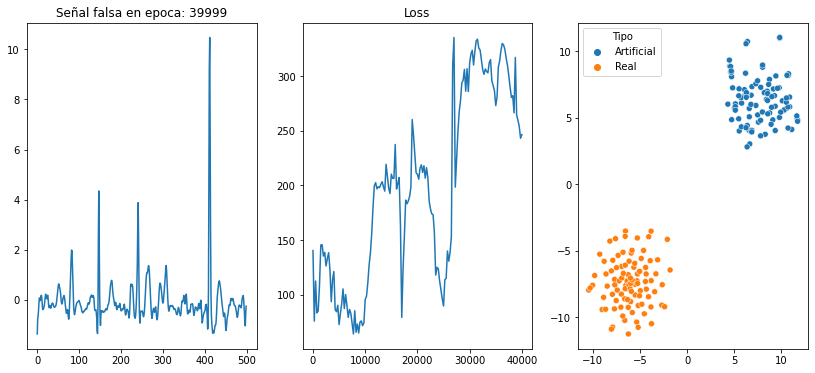

Loss:  211.2973175048828
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


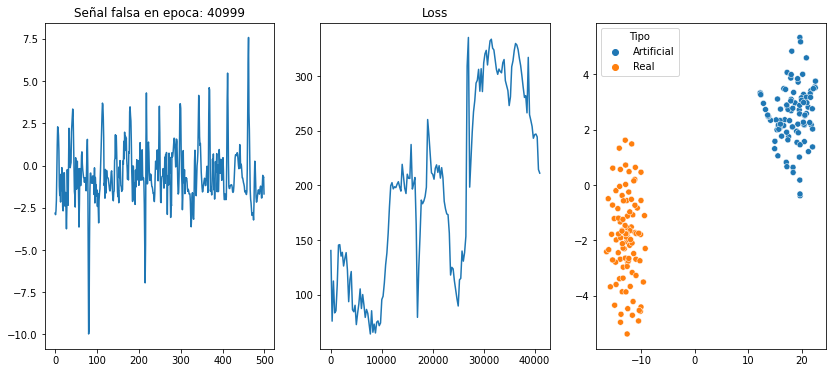

Loss:  187.943603515625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


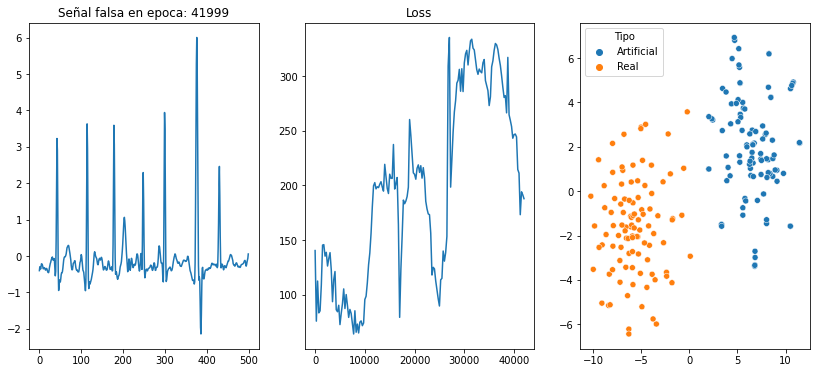

Loss:  193.19508361816406
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


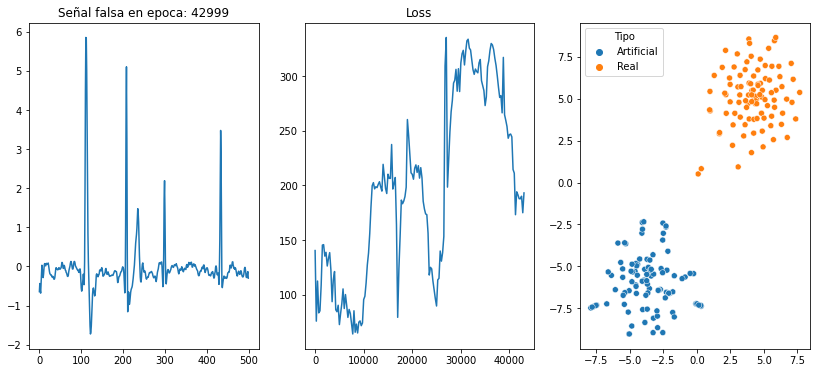

Loss:  200.1646270751953
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


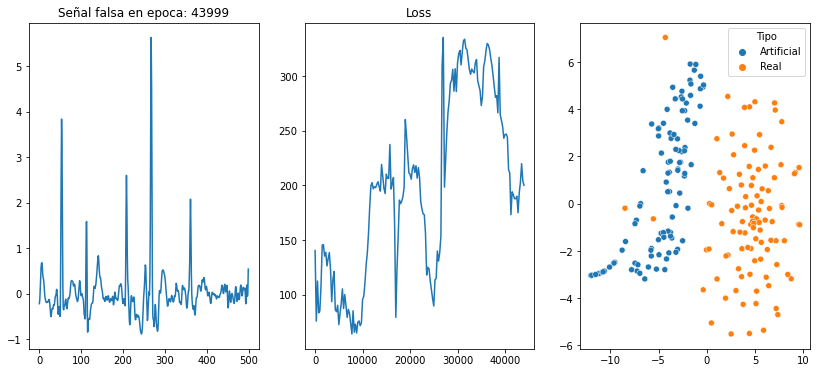

Loss:  252.00546264648438
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


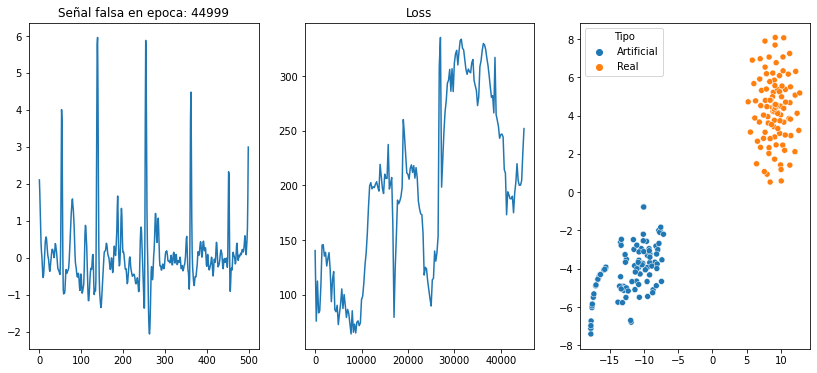

Loss:  227.32518005371094
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


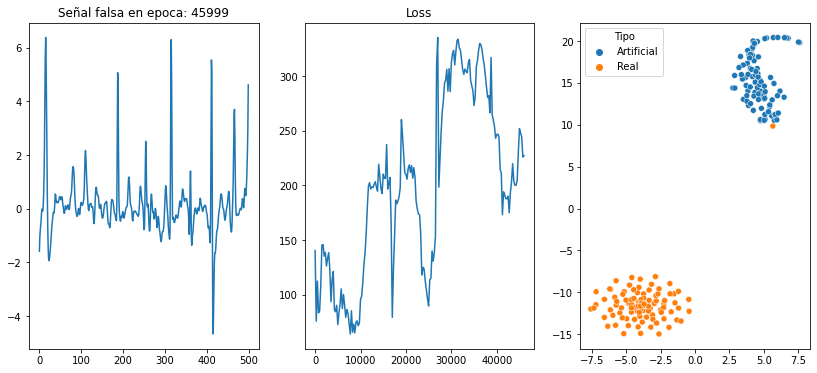

Loss:  255.19635009765625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


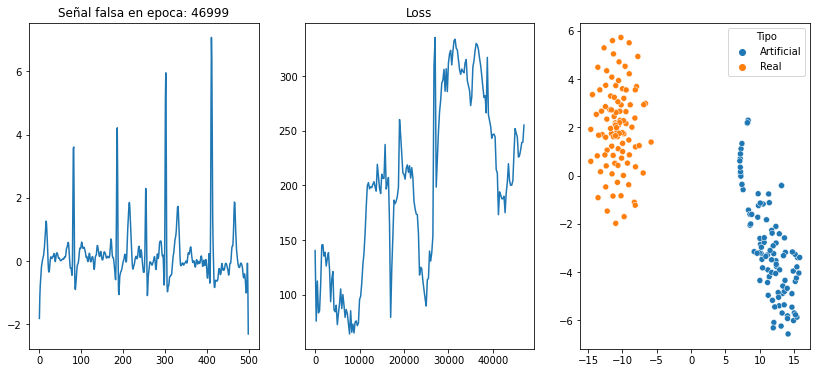

Loss:  291.4962158203125
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


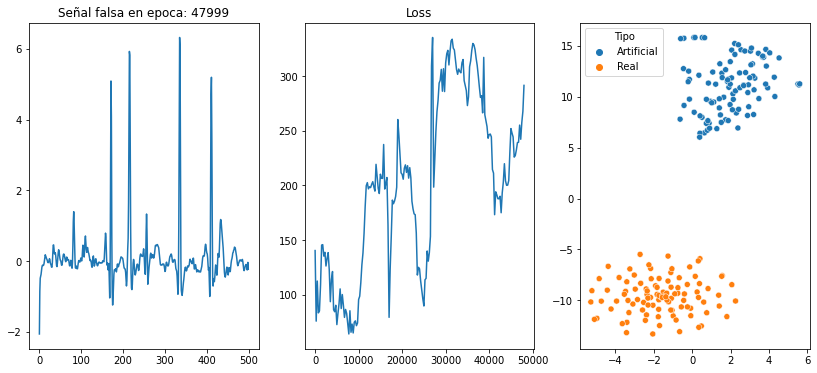

Loss:  349.85296630859375
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


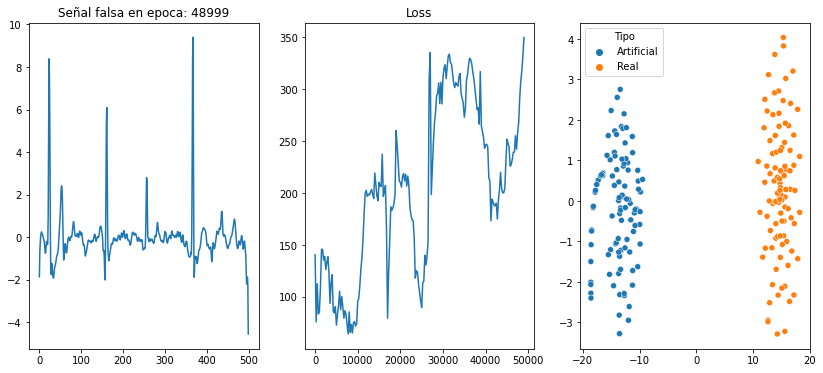

Checkpoint en época: 49999
Loss:  356.07598876953125
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


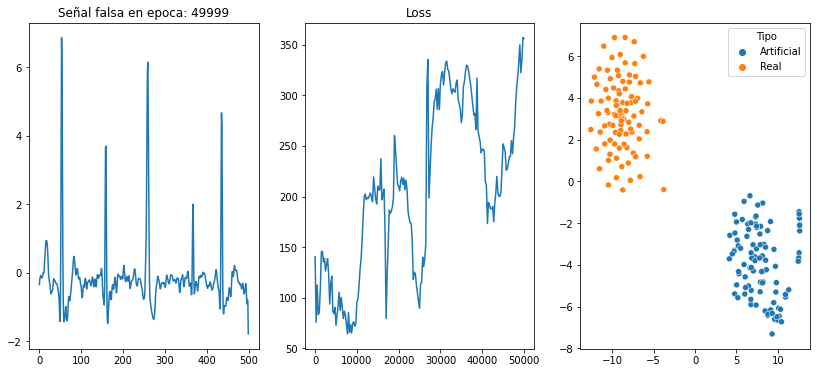

Loss:  381.4251403808594
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


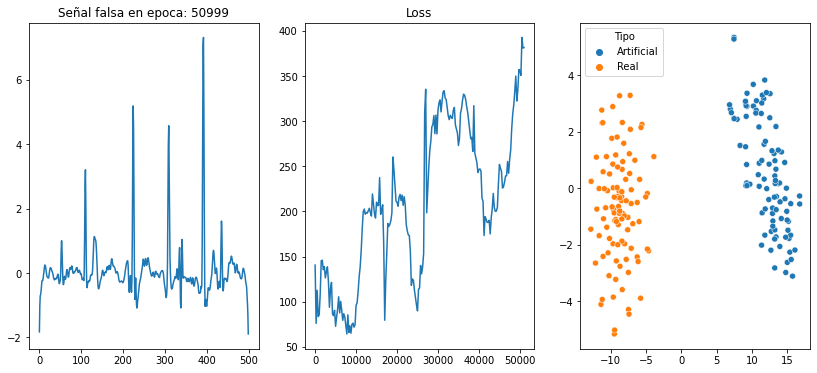

Loss:  380.6675109863281
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


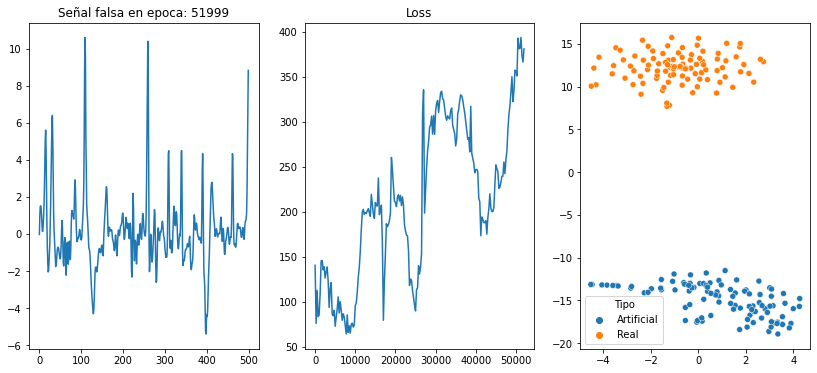

Loss:  335.74835205078125
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


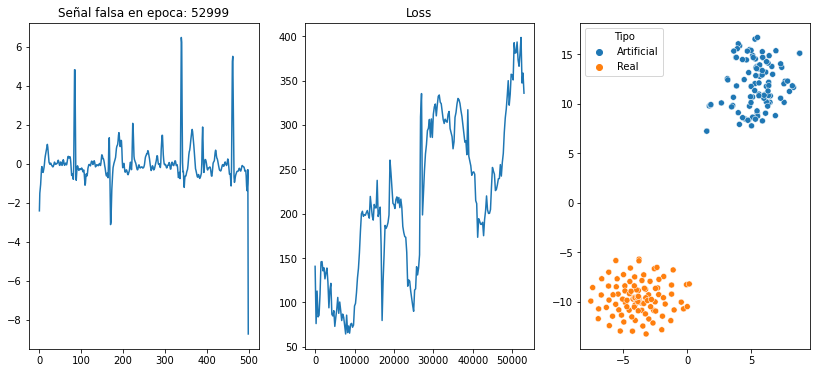

Loss:  320.260009765625
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


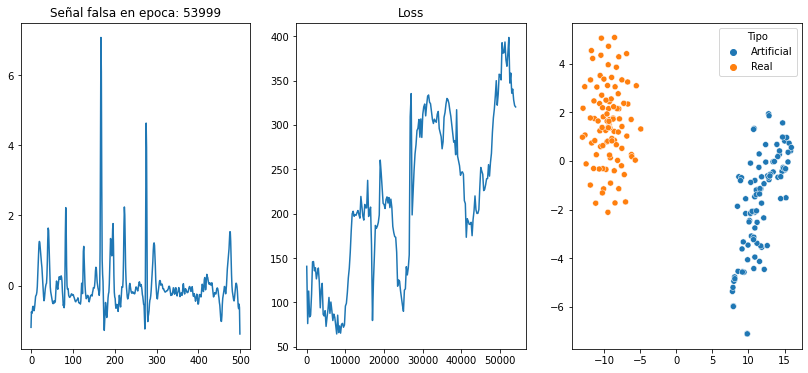

Loss:  318.5369567871094
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


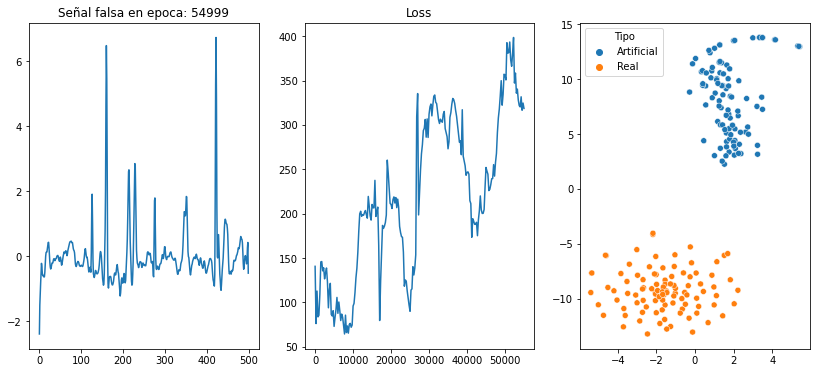

Loss:  271.0738830566406
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


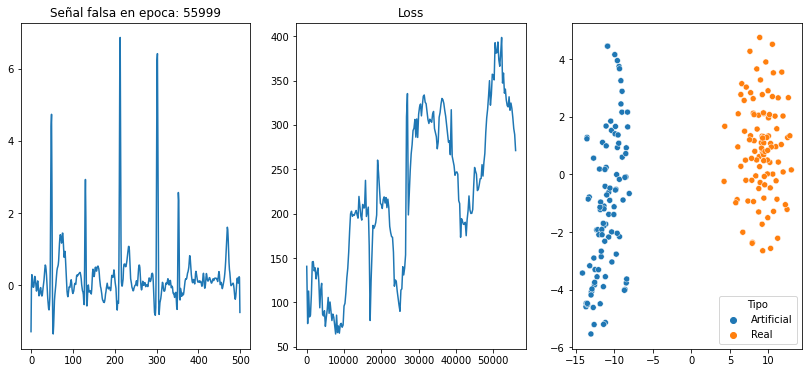

Loss:  236.81259155273438
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


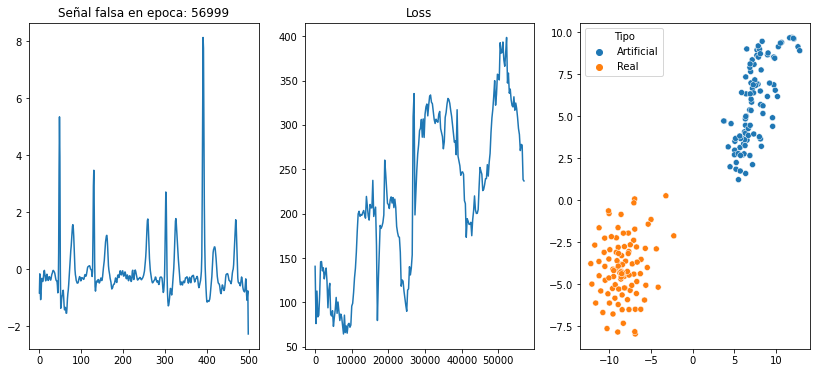

Loss:  187.2333984375
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


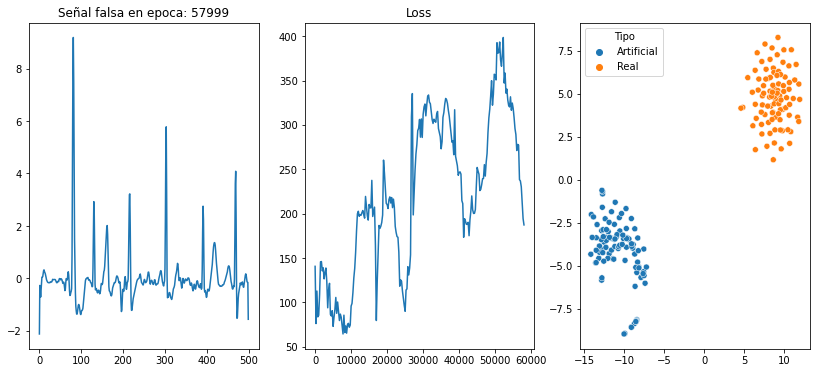

Loss:  241.0768585205078
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


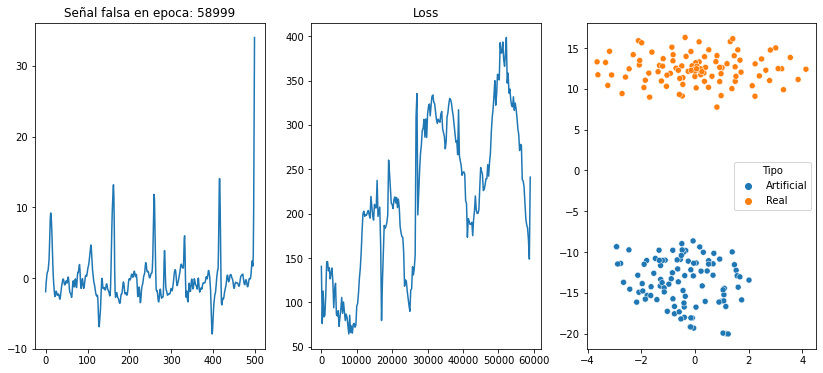

Checkpoint en época: 59999
Loss:  119.74354553222656
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


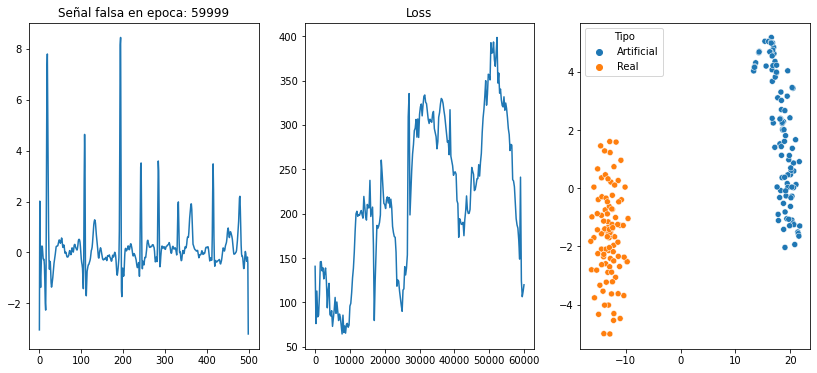

Loss:  117.15847778320312
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


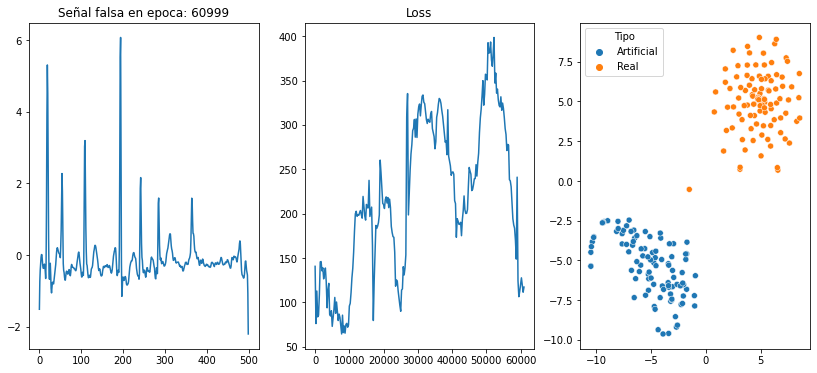

Loss:  117.50199890136719
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


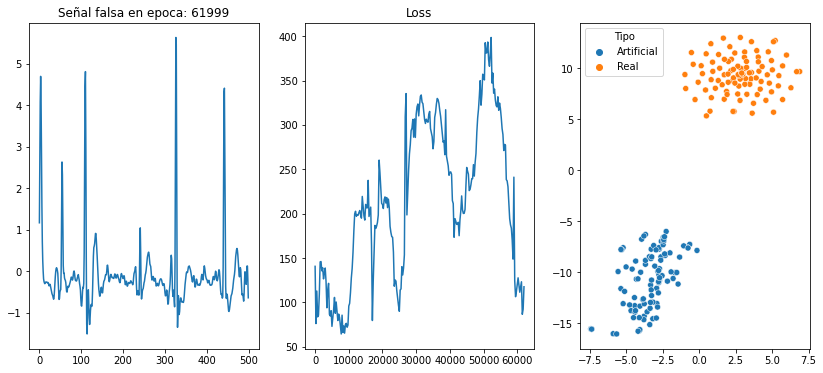

Loss:  94.47686767578125
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


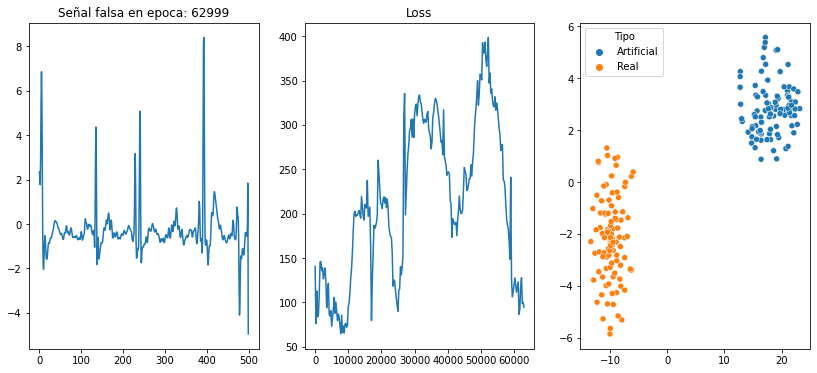

Loss:  126.90375518798828
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


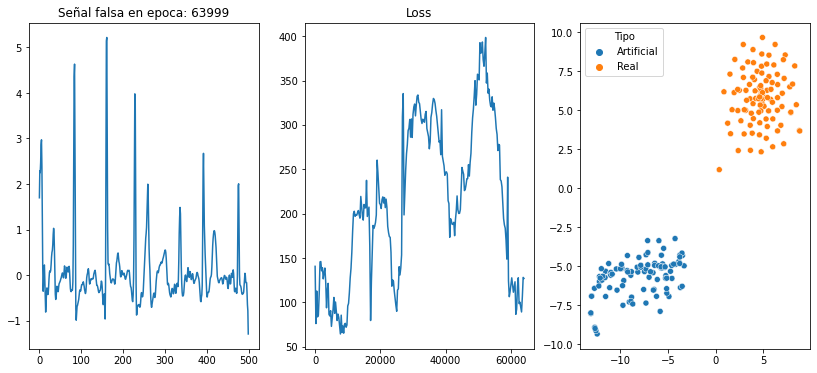

Loss:  89.59637451171875
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


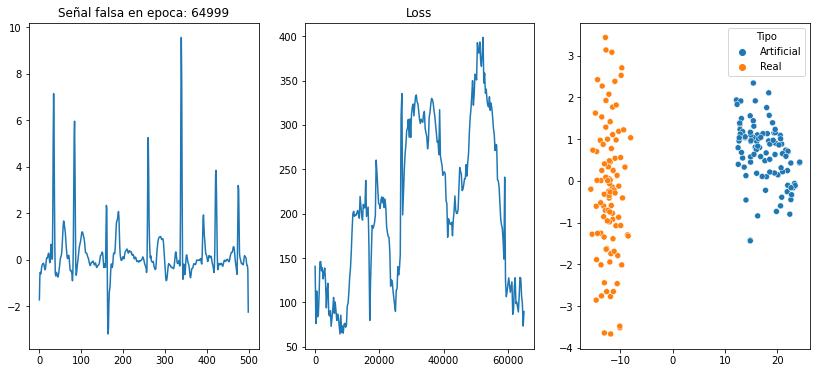

Loss:  114.05664825439453
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


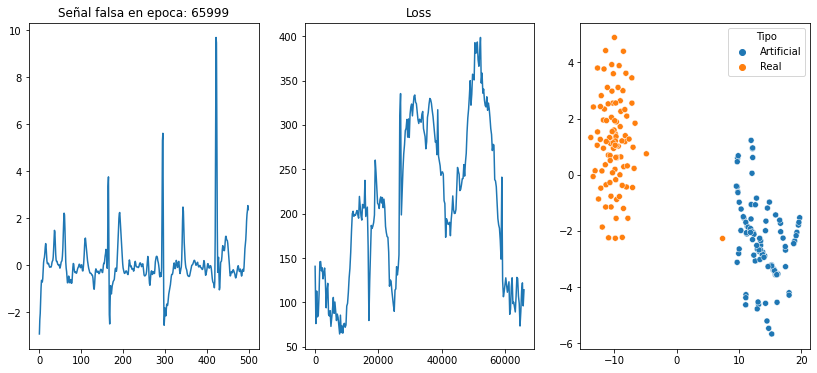

Loss:  102.24701690673828
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


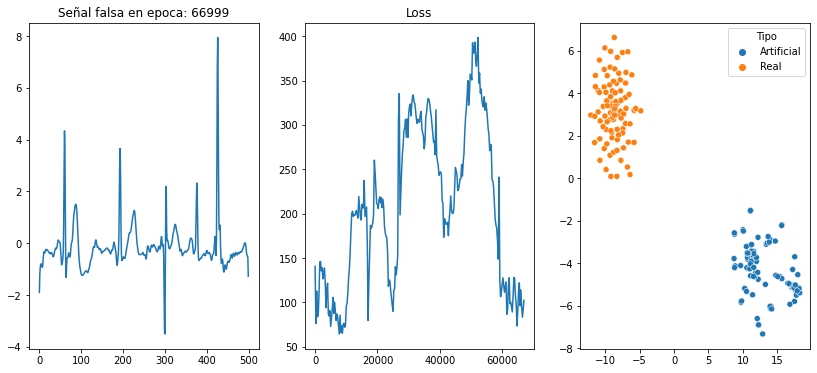

Loss:  150.4825897216797
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


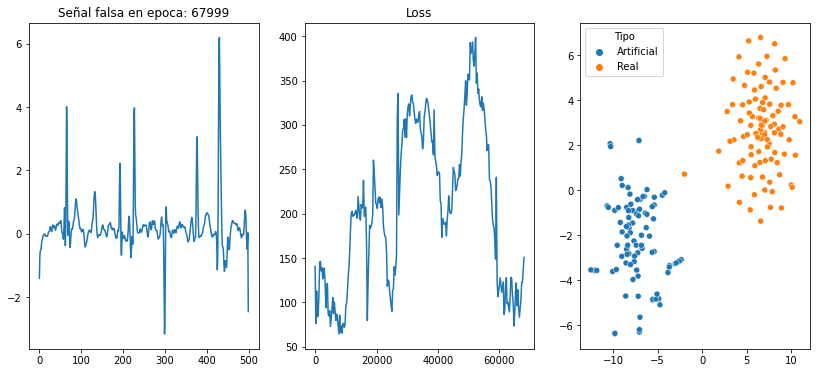

Loss:  152.55162048339844
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


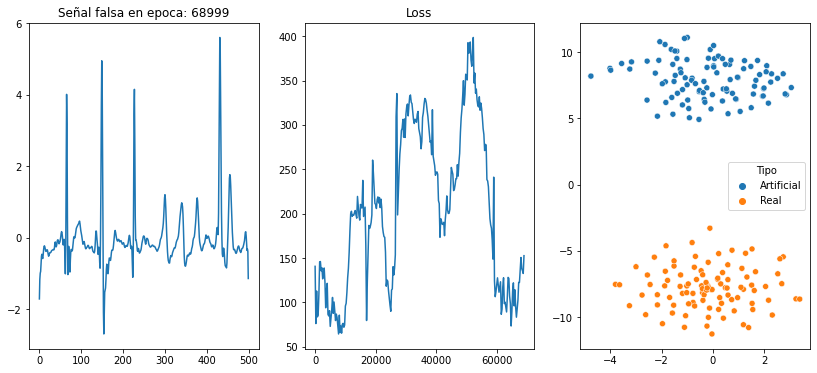

Checkpoint en época: 69999
Loss:  173.86532592773438
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


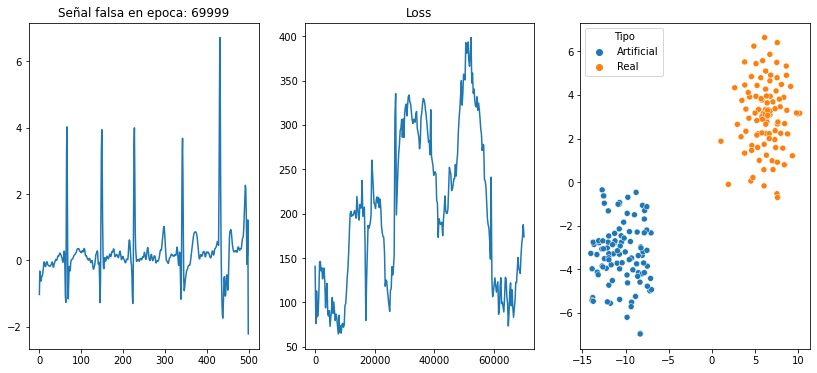

Loss:  134.8298797607422
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


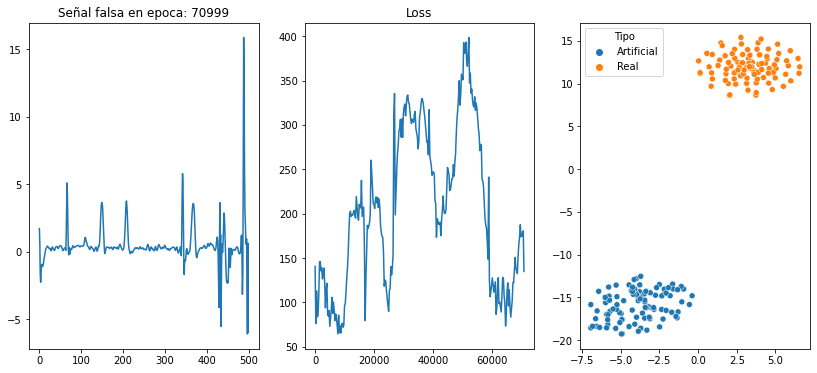

KeyboardInterrupt: ignored

In [ ]:
modelo.Crear_Gan()
modelo.train(dimensiones=50,epocas=100000,n_batch=250)

En el entrenamietno anterior, como el resultado de la época 569999 fue bastante bueno visualmente, se va a guardar.

In [ ]:
with open('/content/drive/MyDrive/ISB/DatosDelModelo/discriminador.json','r') as discriminador_json:
  discriminador_json_cargado = discriminador_json.read()

discriminador = model_from_json(discriminador_json_cargado)
discriminador.load_weights("/content/drive/MyDrive/ISB/DatosDelModelo/discriminador_weights.h5")


with open('/content/drive/MyDrive/ISB/DatosDelModelo/generador.json','r') as generador_json:
  generador_json_cargado = generador_json.read()

generador = model_from_json(generador_json_cargado)
generador.load_weights("/content/drive/MyDrive/ISB/DatosDelModelo/generador_weights.h5")


In [ ]:
modelo = GAN(df_procesada_standar)
modelo.discriminador = discriminador
modelo.generador = generador
modelo.discriminador.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Existe cierta inestabilidad en la última onda pero en su mayoría el resultado fue satisfactorio

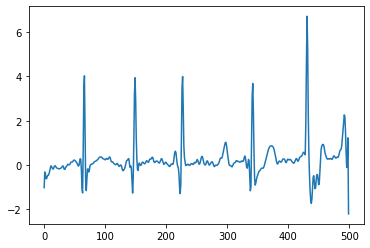

In [ ]:
x,_ = modelo.Datos_Falsos(50,1,True)
plt.plot(x[0])
plt.show()

In [ ]:
generador_json = modelo.generador.to_json()
with open("/content/drive/MyDrive/ISB/DatosDelModelo/buen_generador2.json", "w") as genera_json:
  genera_json.write(generador_json)
modelo.generador.save_weights("/content/drive/MyDrive/ISB/DatosDelModelo/buen_generador2_weights.h5")

discriminador_json = modelo.discriminador.to_json()
with open("/content/drive/MyDrive/ISB/DatosDelModelo/buen_discriminador2.json", "w") as discrimina_json:
  discrimina_json.write(discriminador_json)
modelo.discriminador.save_weights("/content/drive/MyDrive/ISB/DatosDelModelo/buen_discriminador2_weights.h5")
    

Re re entreno

In [ ]:
with open('/content/drive/MyDrive/ISB/DatosDelModelo/discriminador.json','r') as discriminador_json:
  discriminador_json_cargado = discriminador_json.read()

discriminador = model_from_json(discriminador_json_cargado)
discriminador.load_weights("/content/drive/MyDrive/ISB/DatosDelModelo/discriminador_weights.h5")

with open('/content/drive/MyDrive/ISB/DatosDelModelo/generador.json','r') as generador_json:
  generador_json_cargado = generador_json.read()

generador = model_from_json(generador_json_cargado)
generador.load_weights("/content/drive/MyDrive/ISB/DatosDelModelo/generador_weights.h5")

modelo = GAN(df_procesada_standar)
modelo.generador = generador
modelo.discriminador = discriminador
modelo.discriminador.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
val_loss = []
epocas_list = []

with open("/content/drive/MyDrive/ISB/DatosDelModelo/val_loss_list.pkl","wb") as loss_values:
  pickle.dump(val_loss, loss_values)

modelo.val_loss = val_loss

with open("/content/drive/MyDrive/ISB/DatosDelModelo/epocas_list.pkl","wb") as epocas_values:
  pickle.dump(epocas_list, epocas_values) 

modelo.epocas_list = epocas_list

Este es otro reentreanmiento desde la época 569999, en este entrenamiento se muestra un problema de convergencia, donde la pérdida de discriminador ya no sube, y por múltiples épocas está confundiendo una señal sintética como real (pese a que esta no tiene la forma deseada)


Loss:  189.8528594970703
Probabilidad:  [[0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


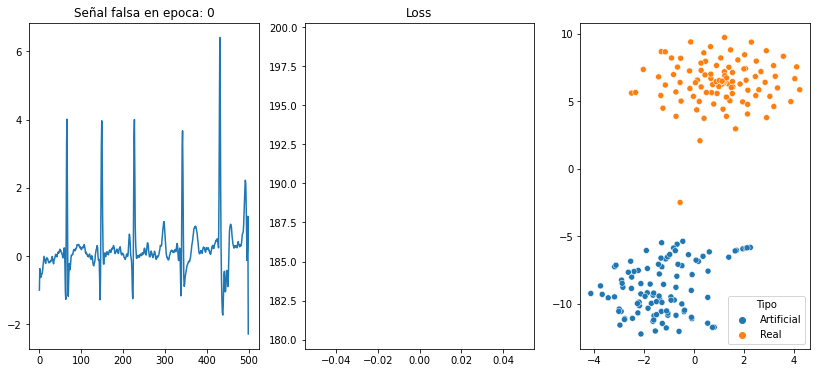

Loss:  41.74532699584961
Probabilidad:  [[7.417112e-19]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


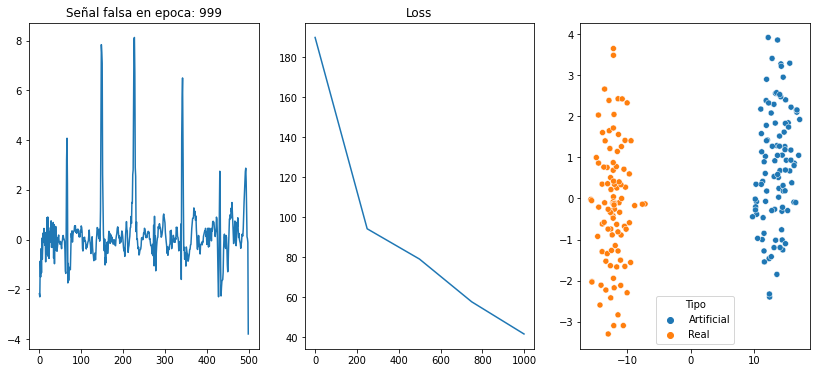

Loss:  1.3548628744314723e-21
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


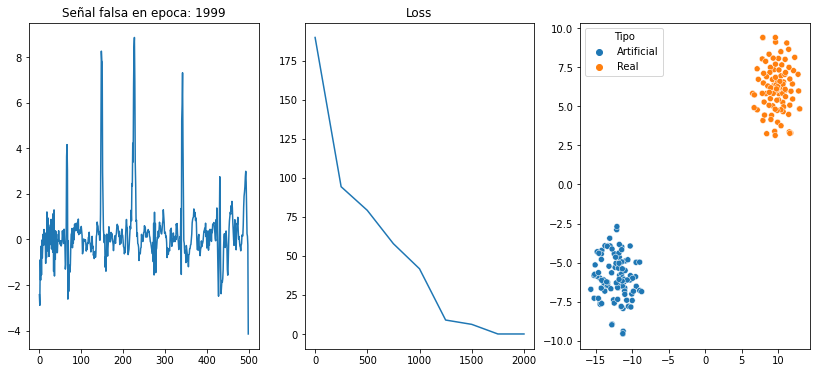

Loss:  3.2706315504079324e-21
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


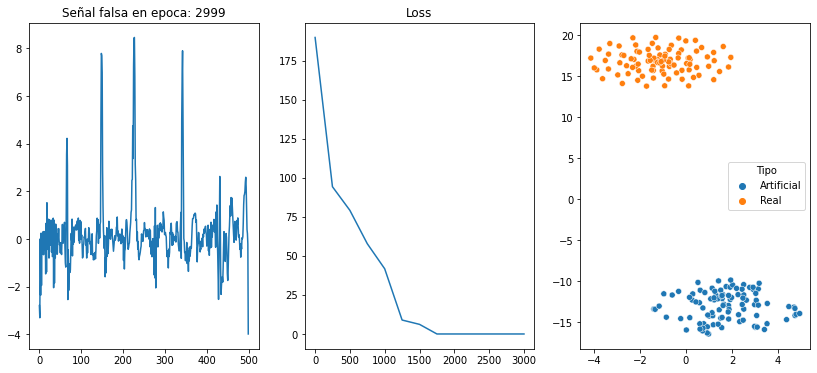

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


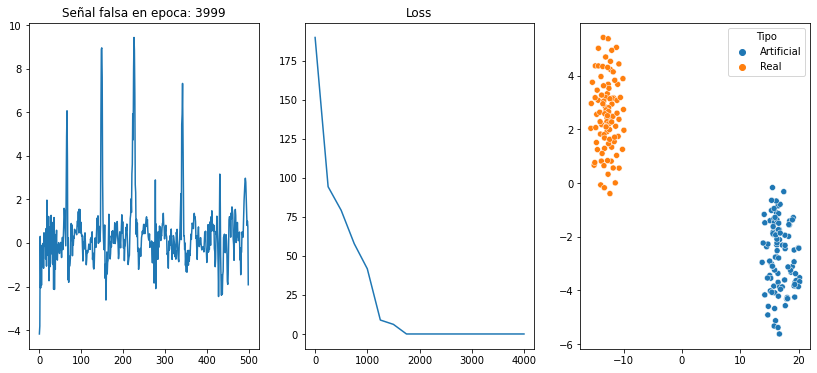

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


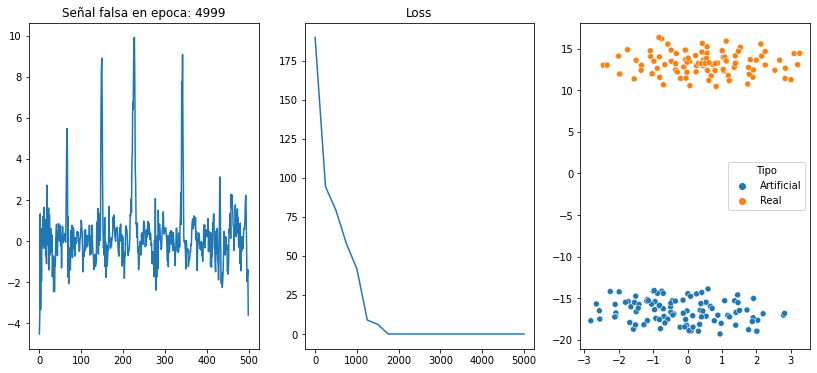

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


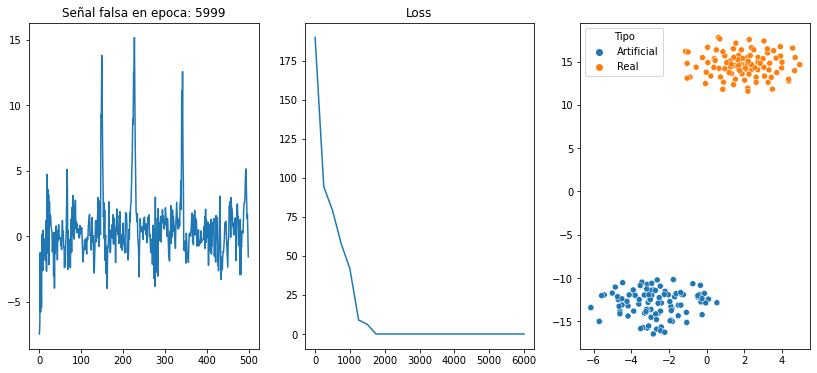

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


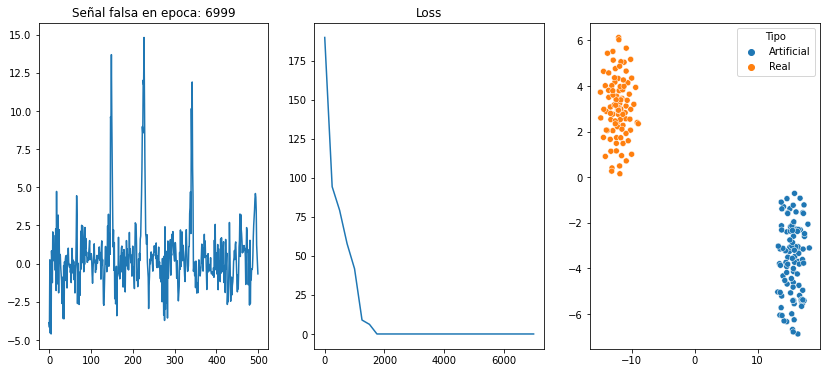

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


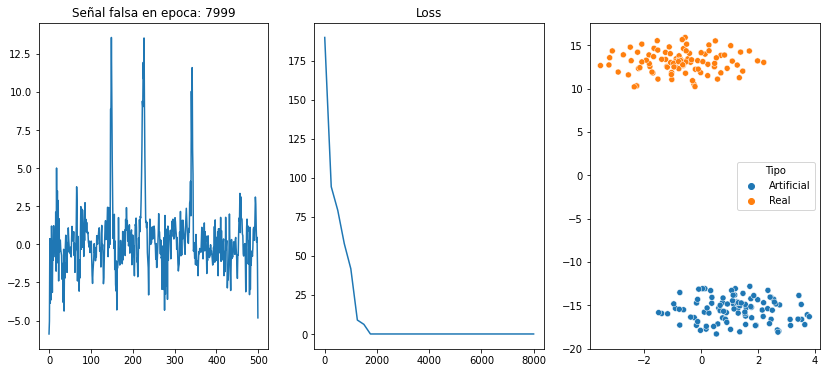

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


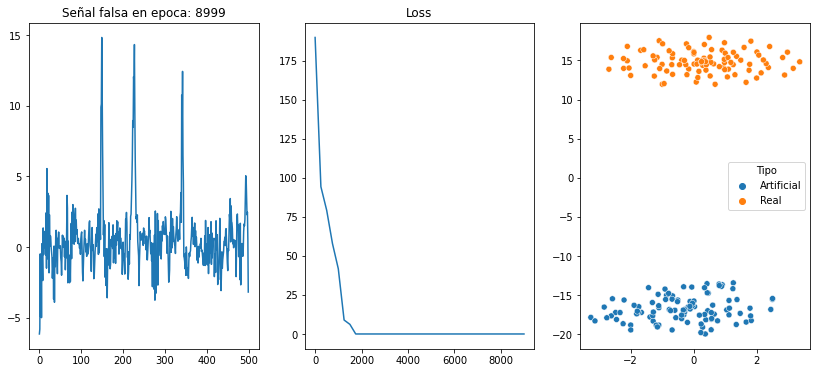

Checkpoint en época: 9999
Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


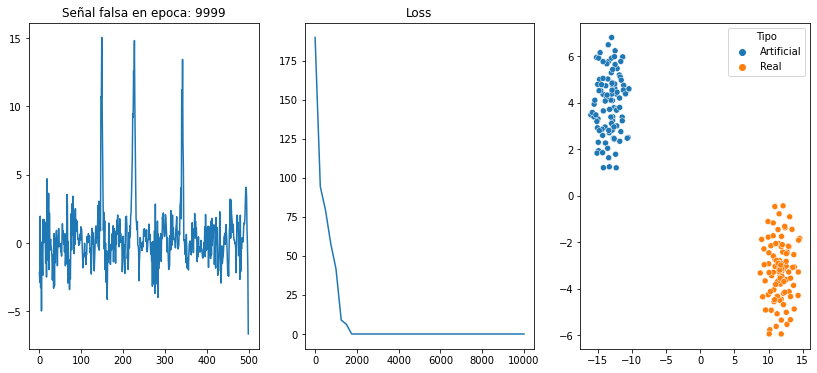

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


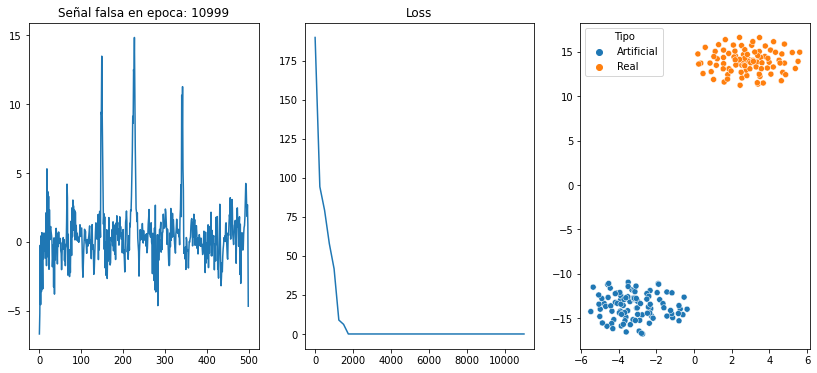

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


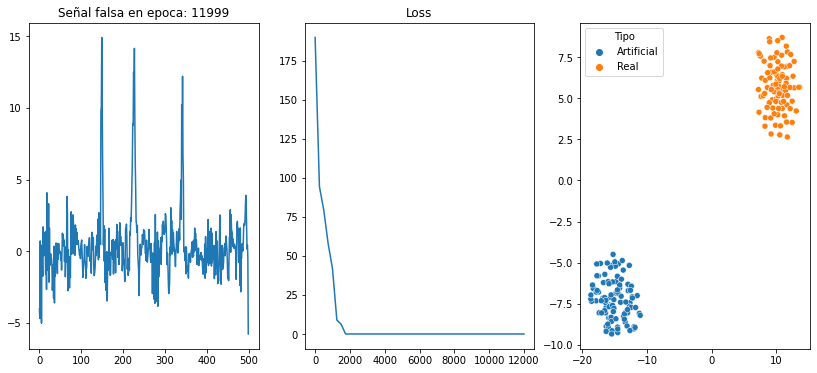

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


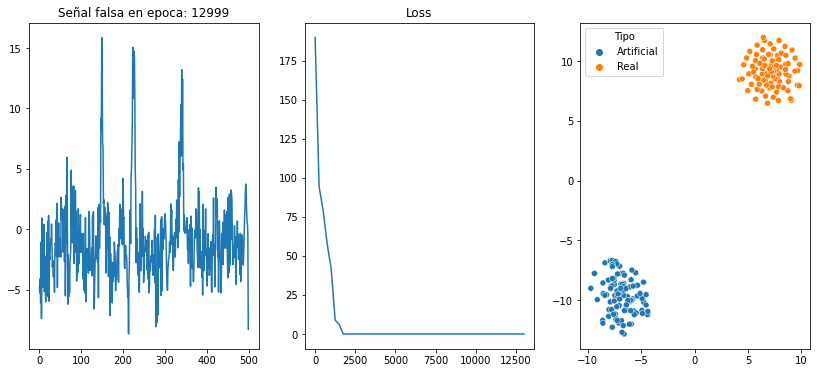

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


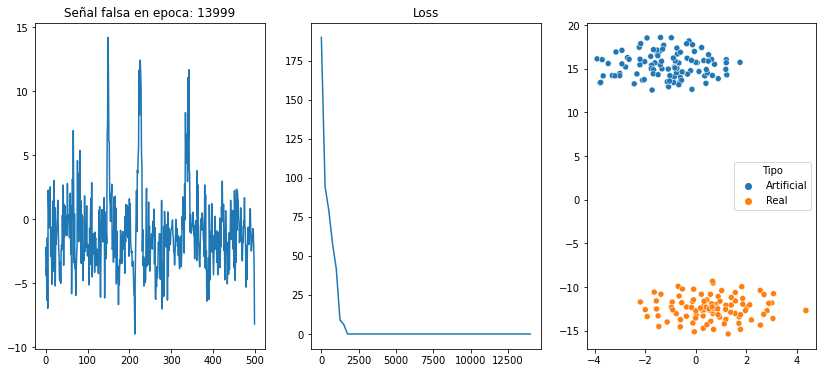

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


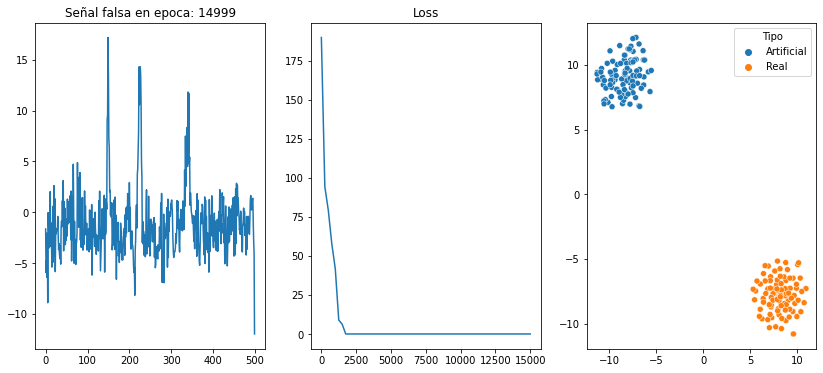

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


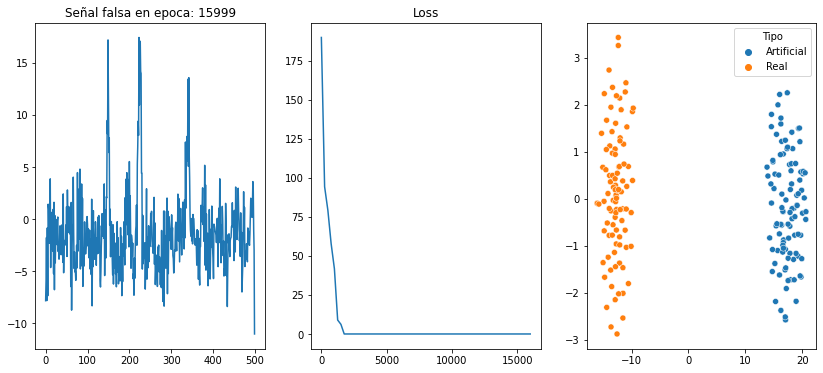

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


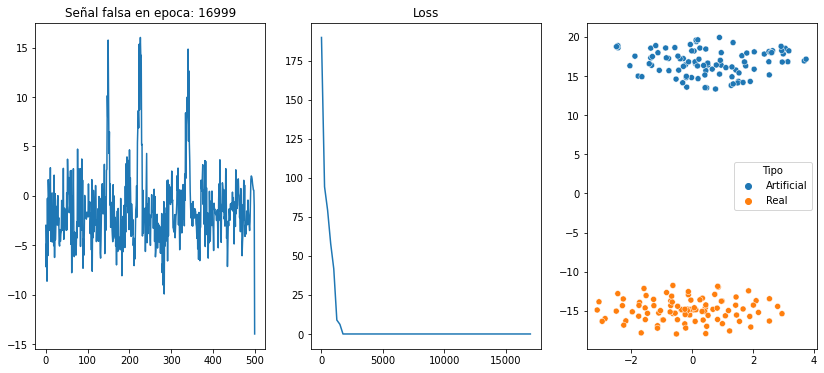

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


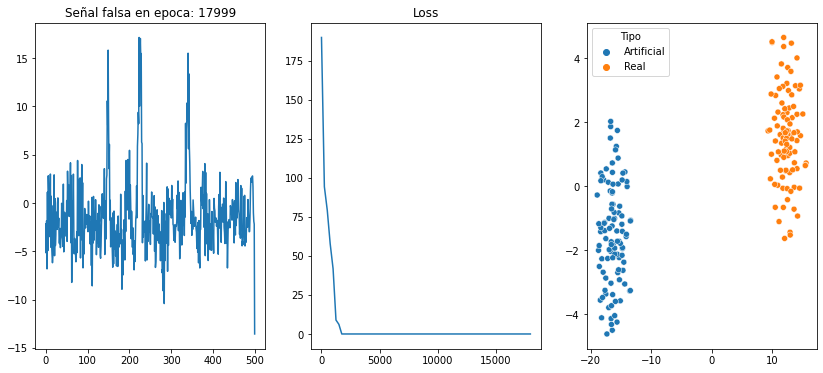

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


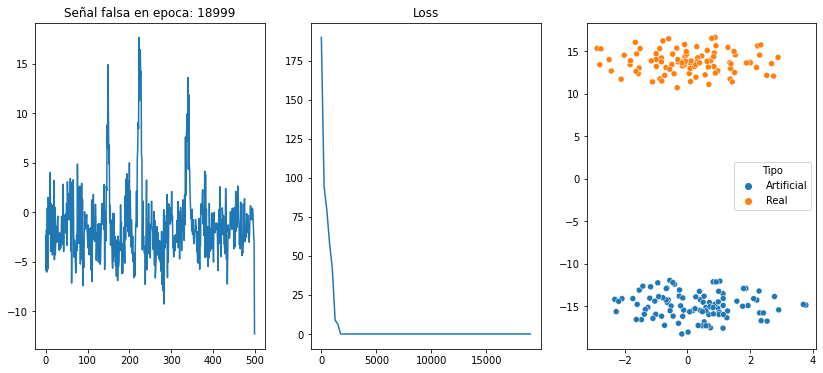

Checkpoint en época: 19999
Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


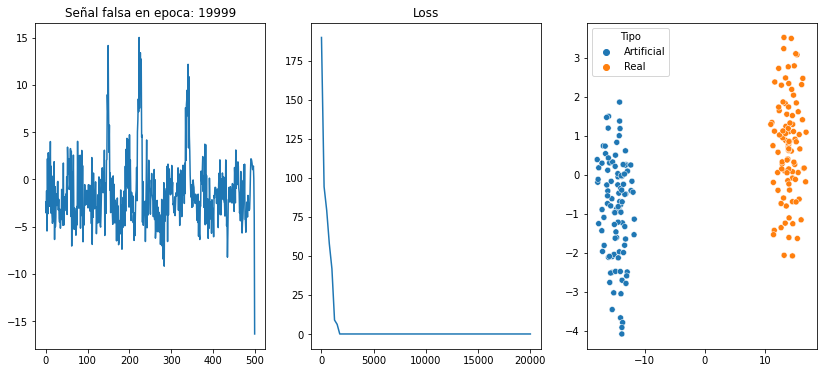

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


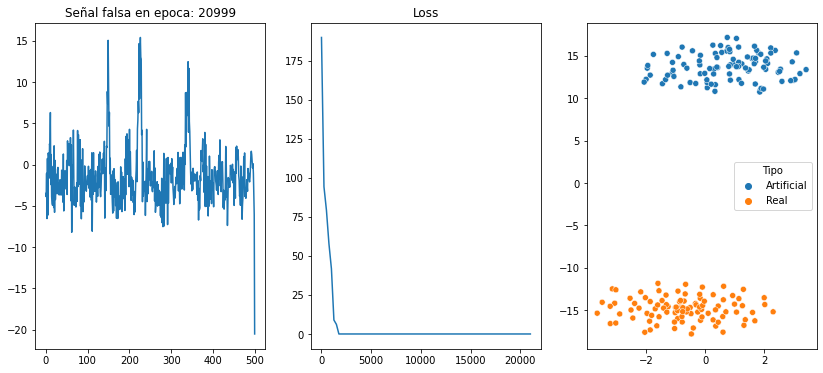

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


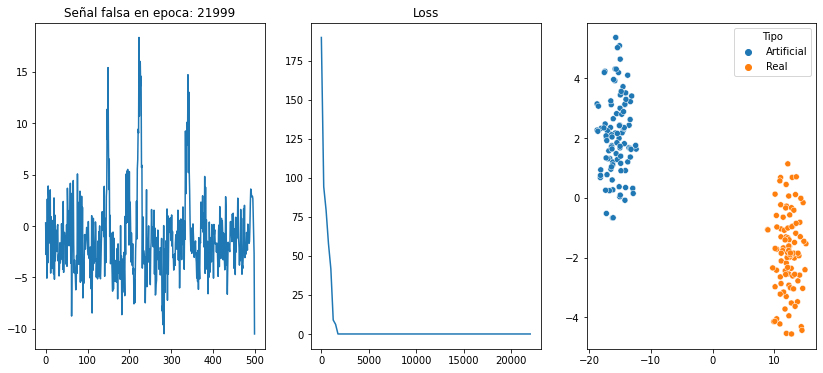

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


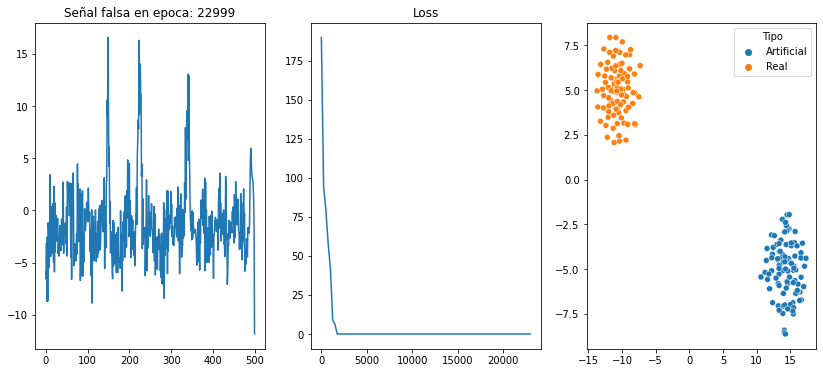

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


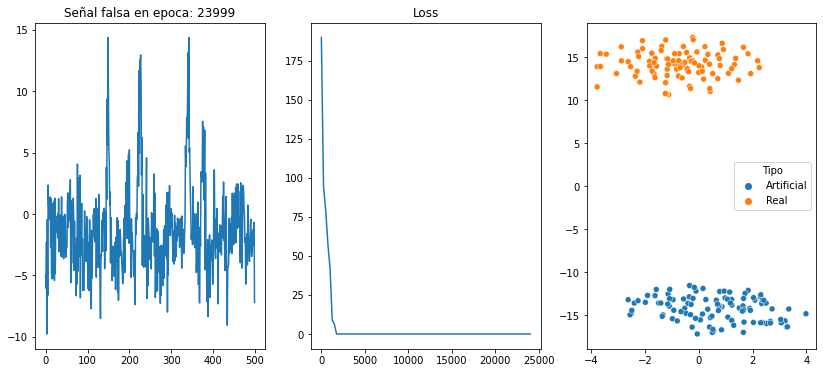

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


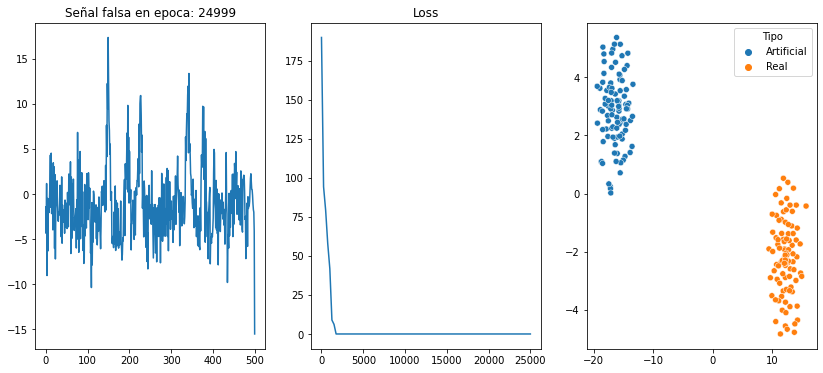

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


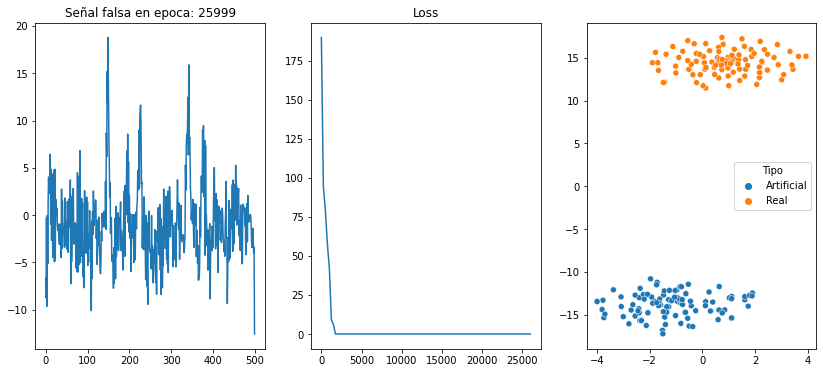

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


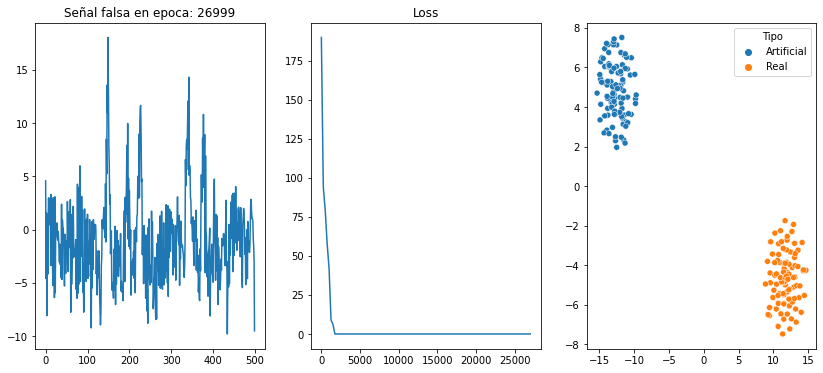

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


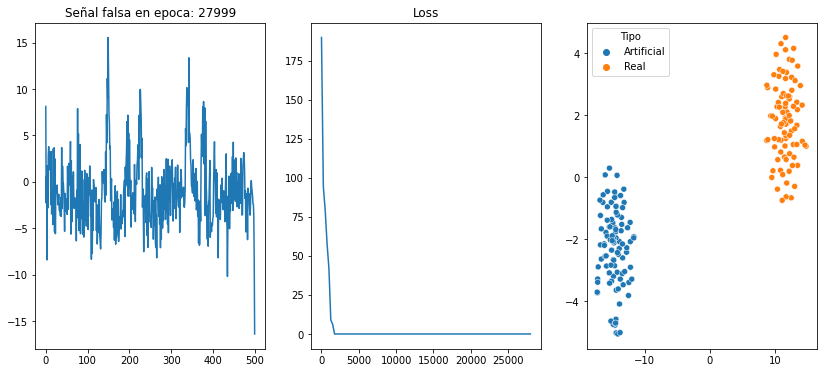

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


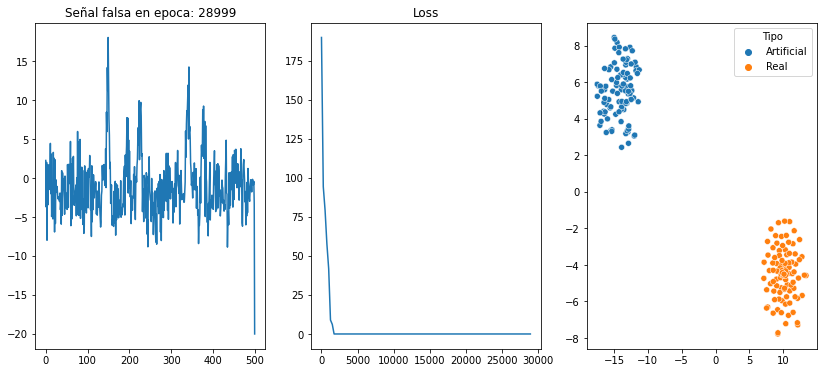

Checkpoint en época: 29999
Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


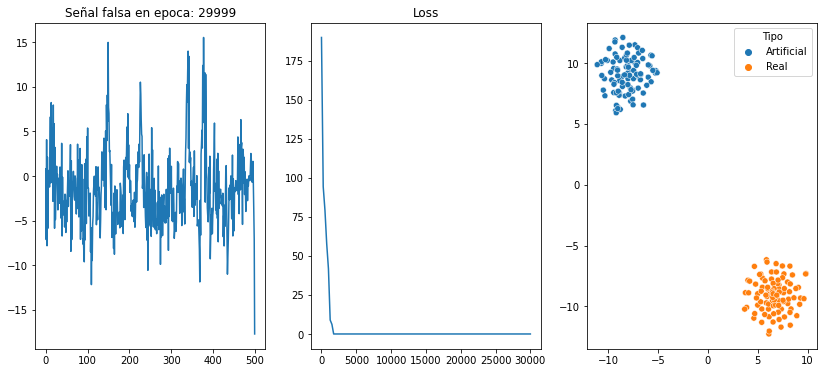

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


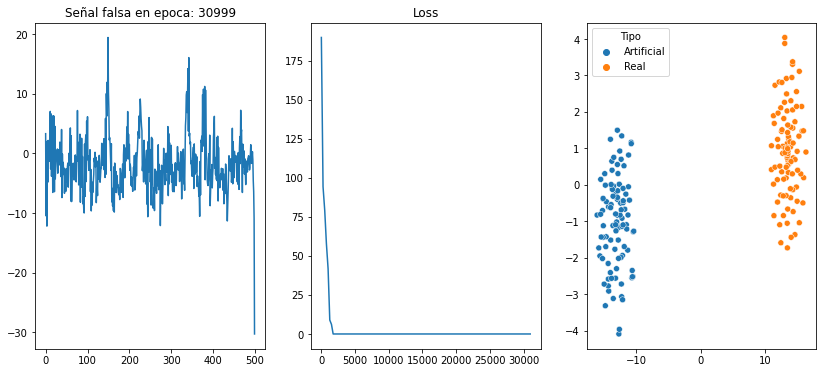

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


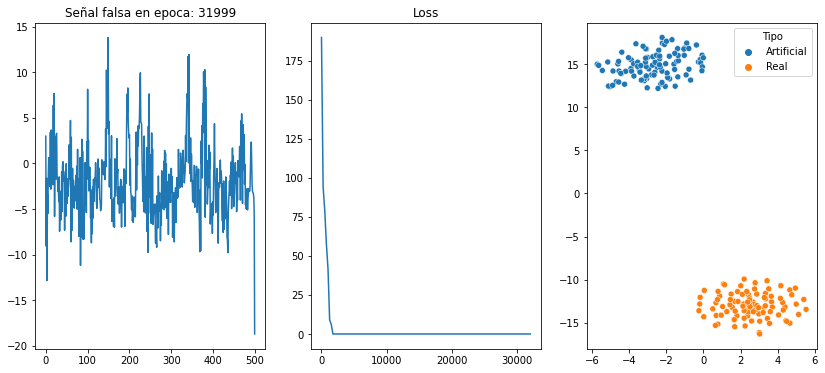

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


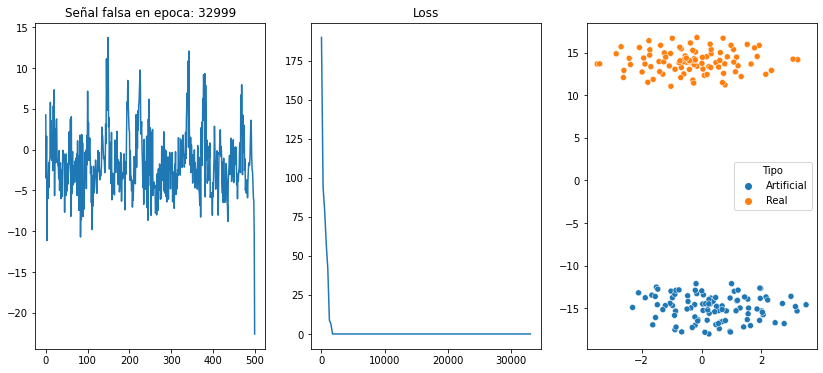

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


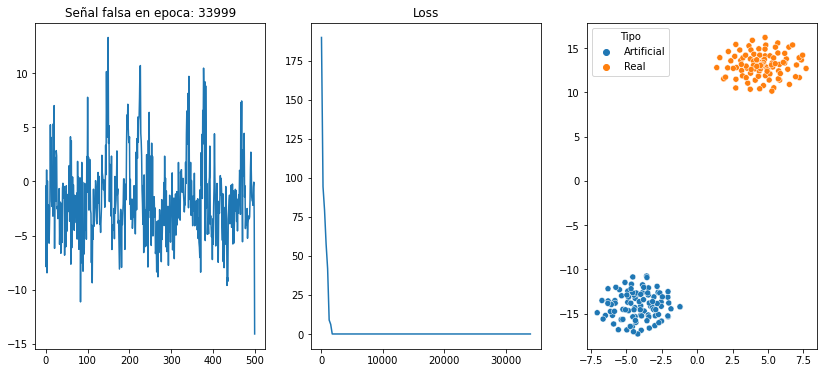

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


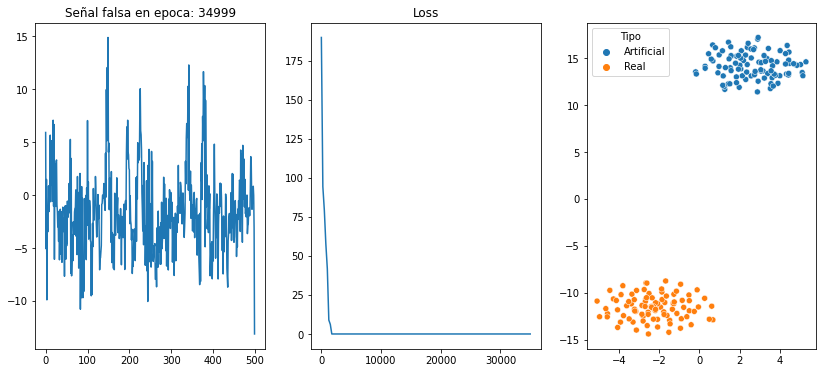

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


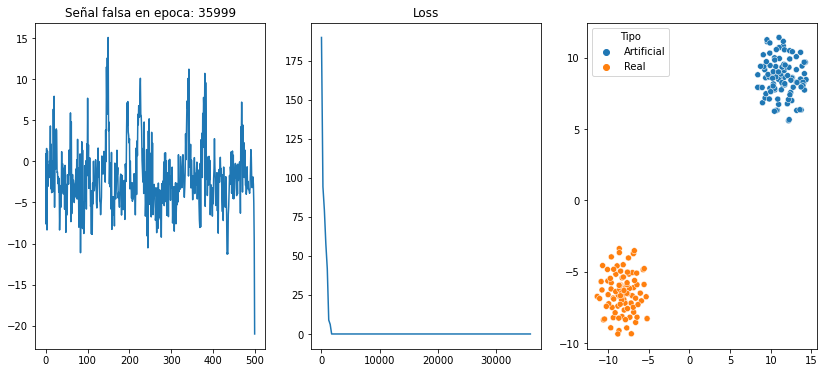

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


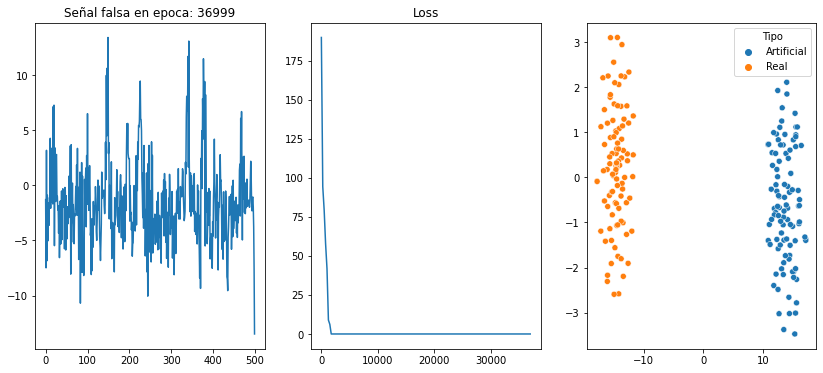

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


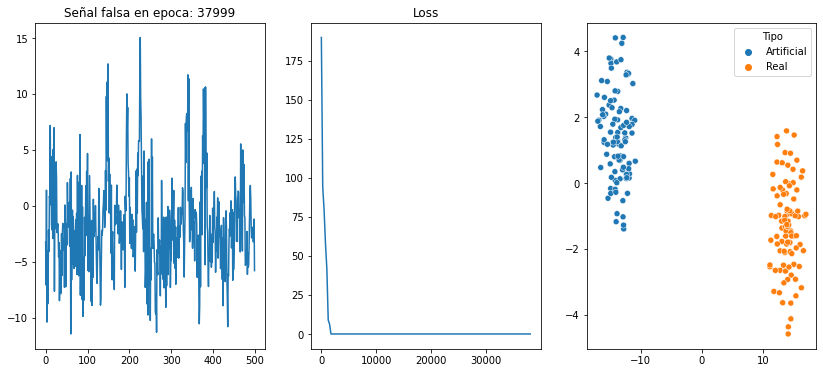

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


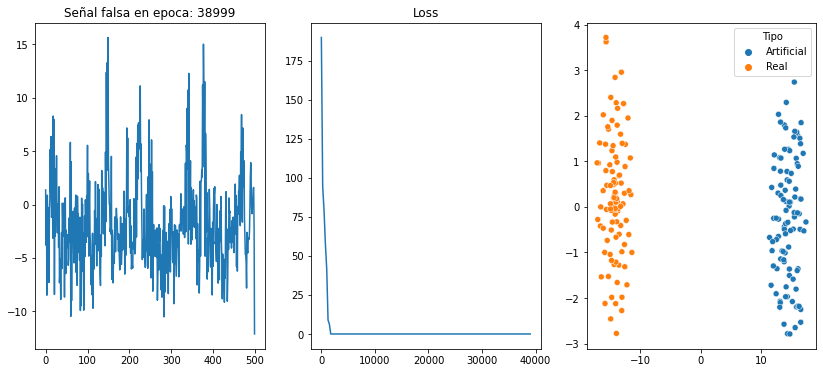

Checkpoint en época: 39999
Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


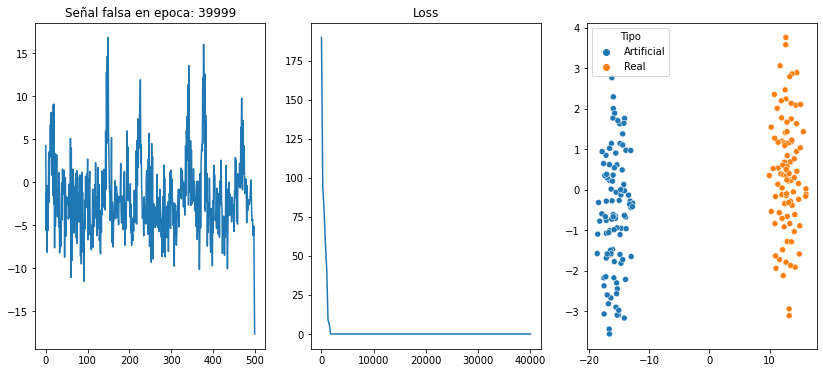

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


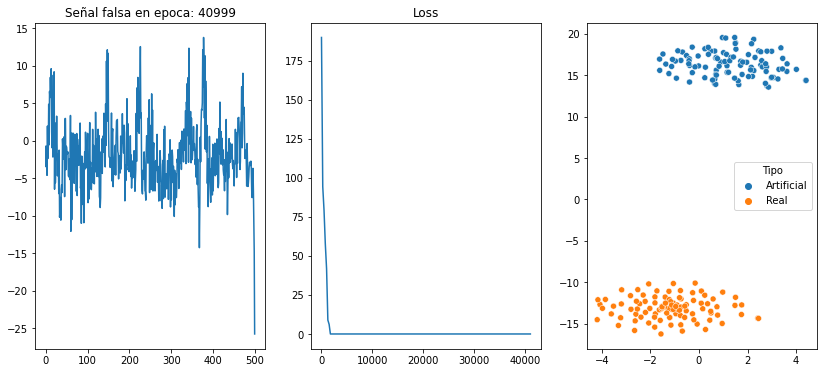

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


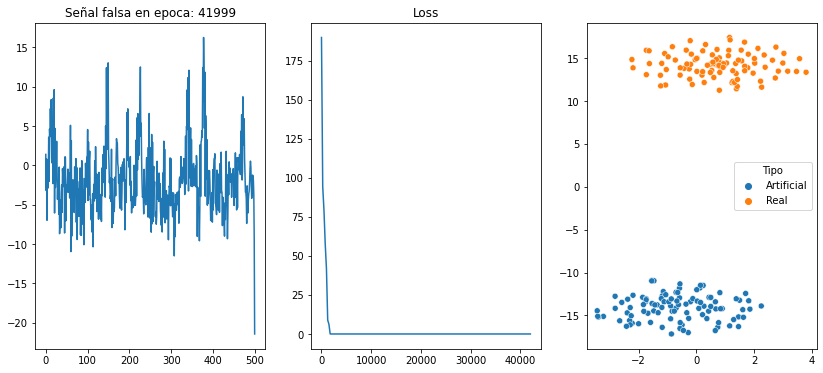

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


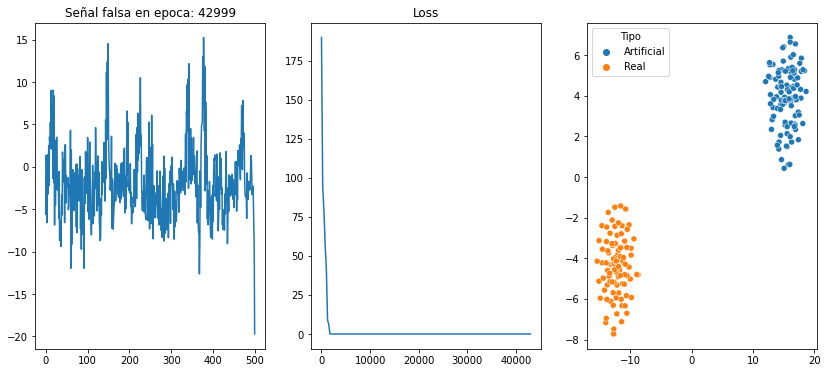

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


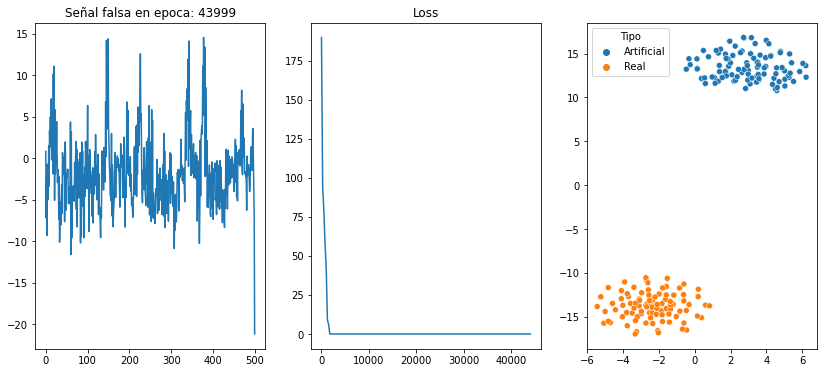

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


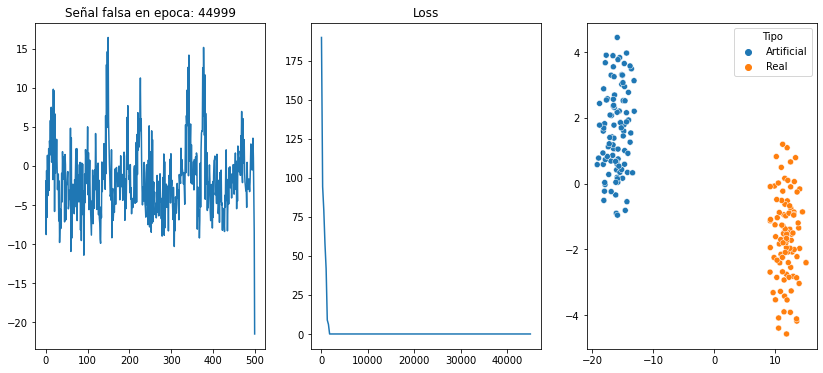

Loss:  0.0
Probabilidad:  [[1.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


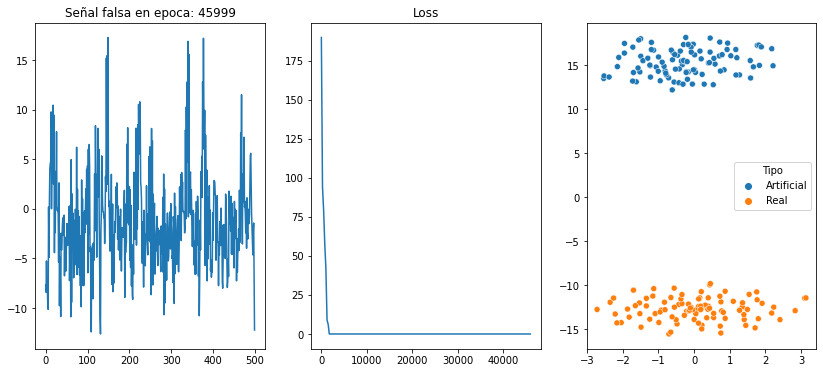

In [ ]:
modelo.Crear_Gan()
modelo.train(dimensiones=50,epocas=100000,n_batch=250)

Debido a la convergencia no se siguió con el entrenamiento, sino que estaremos usando los dos mejores resultados, que incluyen:

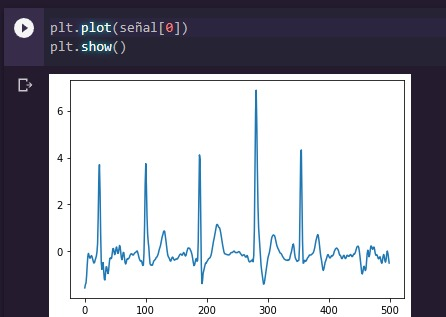


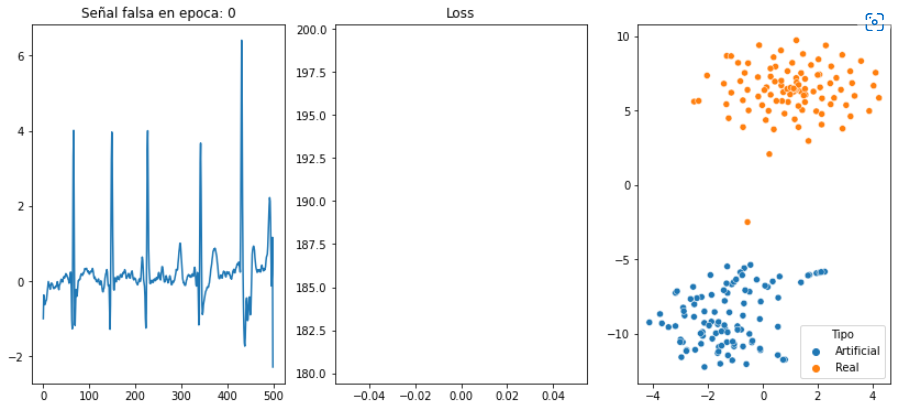